In [ ]:
!nvidia-smi

Mon Apr 25 10:15:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full==1.4.7 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html
!pip install terminaltables timm mmcls

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 56.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.0 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 78.1 MB/s eta 0:00:15tcmalloc: large alloc 1147494400 bytes == 0x562424ac8000 @  0x7f57b8083615 0x5623eb23817c 0x5623eb31847a 0x5623eb23af9d 0x5623eb32cd4d 0x5623eb2aeec8 0x5623eb2a9a2e 0x5623eb23c88a 0x5623eb2aed30 0x5623eb2a9a2e 0x5623eb23c88a 0x5623eb2ab719 0x5623eb32db76 0x5623eb2aad95 0x5623eb32db76 0x5623eb2aad95 0x5623eb32db76 0x5623eb2aad95 0x5623eb23cce9 0x5623eb280579 0x5623eb23b902 0x5623eb2aec4d 0x5623eb2a9a2e 0x5623eb23c88a 0x562

In [ ]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation, BeitConfig, DetrFeatureExtractor, DetrForSegmentation
from PIL import Image
import requests
import torch
import os
import numpy as np
from torch import nn
import torch
import torchvision
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import random_split
import pickle
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

In [ ]:
!unzip "/content/drive/Shareddrives/Food Analytic/Data/FoodSeg103.zip" -d .
!unzip "/content/drive/Shareddrives/Food Analytic/Data/FoodSeg103Classification.zip" -d .
!unzip "/content/drive/Shareddrives/Food Analytic/Data/FoodSeg73.zip" -d .
!unzip "/content/drive/Shareddrives/Food Analytic/Data/FoodSeg103Test.zip" -d .
#!unzip "/content/drive/MyDrive/Senior Project/FoodSeg103.zip" -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./FoodSeg73/Images/ann_dir/train/00001258.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001260.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001262.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001267.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001270.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001272.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001274.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001281.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001282.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001283.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001291.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001295.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001297.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001299.png  
  inflating: ./FoodSeg73/Images/ann_dir/train/00001301.png  
  inflating: ./FoodSeg73/Images/an

In [ ]:
# root_path_image = 'C:/Users/Kombangkoe Dias/Downloads/FoodSeg103/FoodSeg103/Images'
# root_path_type = 'C:/Users/Kombangkoe Dias/Downloads/FoodSeg103/FoodSeg103/types'
# root_path = 'C:/Users/Kombangkoe Dias/Downloads/FoodSeg103'
root_path = '/content/FoodSeg103'
root_path73 = '/content/FoodSeg73'

data_path = root_path

root_path_image = f'{data_path}/Images'
root_path_type = f'{data_path}/types'
drive_path = '/content/drive/MyDrive/Senior Project'
shared_drive_path = '/content/drive/Shareddrives/Food Analytic'
# root_path_image = '/home/kbd/Desktop/data/FoodSeg103/FoodSeg103/Images'
# root_path_type = '/home/kbd/Desktop/data/FoodSeg103/FoodSeg103/types'
# root_path = '/home/kbd/Desktop/data/FoodSeg103/FoodSeg103'


In [ ]:
class Utils:
    def __init__(self, root_path):
        self.root_path = root_path
        self.ingredients = self.getIngredients()
        self.id2label = self.getid2label()
        self.label2id = self.getlabel2id()
        self.numPicsTrain = self.getClassificationNumPics(train=True)
        self.numPicsTest = self.getClassificationNumPics(train=False)
    def getIngredients(self):
        ingredients = dict()
        with open(f"{self.root_path}/category_id.txt") as f:
            for line in f:
                data = line.strip().split()
                Id = data[0]
                food_type = ' '.join(data[1:])
                ingredients[int(Id)] = food_type
        return ingredients
        return False
    def getid2label(self):
        id2label = dict()
        for id in self.ingredients.keys():
          id2label[id] = self.ingredients[id]
        return id2label
    def getlabel2id(self):
        label2id = dict()
        for id, val in self.ingredients.items():
          label2id[val] = id
        return label2id
    def getClassificationNumPics(self, train=True):
      path = '/content/FoodSeg103Classification/'
      path =  path + "train" if train else path + 'test'
      numPics = []
      for class_name in os.listdir(path):
        try:
          numPics.append((class_name, len(os.listdir(os.path.join(path, class_name)))))
        except:
          pass
      return numPics

class ConfigClass():
  def __init__(self, num_labels, id2label, label2id, image_size=640, patch_size=640, auxiliary_loss_weight=0.4, use_return_dict=False, output_hidden_states=False):
    self.num_labels = num_labels
    self.id2label = id2label
    self.label2id = label2id
    self.auxiliary_loss_weight = auxiliary_loss_weight
    self.image_size = image_size
    self.use_return_dict = use_return_dict
    self.output_hidden_states = output_hidden_states

In [ ]:
utils = Utils(data_path)
config = ConfigClass(num_labels=len(utils.id2label.keys()), id2label=utils.id2label, label2id=utils.label2id)

In [ ]:
# class Transforms():
#   def __init__(self):
#     self.transforms = [self.randomCrop]
#     self.randomCrop = None 
  
#   def __call__(self,img,mask):
#     pass 

class TransformsGenerator():
  def __init__(self, tfms):
    self.tfms = tfms
  def __call__(self, img, mask):
    for t in self.tfms:
      img, mask = t(img, mask)
    return img, mask

class randomCrop():
    def __init__(self,cropw, croph):
      self.cropw = cropw
      self.croph = croph
    def __call__(self, img, mask):
      w, h = img.size
      startw = 0
      starth = 0
      if self.cropw < w:
        startw = np.random.randint(0, w-self.cropw)
      if self.croph < h:
        starth = np.random.randint(0, h-self.croph)
      endw = startw + min(self.cropw,w)
      endh = starth + min(self.croph,h)
      pos = (startw, starth, endw, endh)

      img = img.crop(pos)
      mask = mask.crop(pos)
      return img, mask

class randomHorizontalFlip():
  def __init__(self, p):
    self.p = p
  def __call__(self, img, mask):
    from PIL import ImageOps
    p = np.random.rand()
    if p > self.p :
      img = ImageOps.mirror(img)
      mask = ImageOps.mirror(mask)
    return img, mask
class randomVerticalFlip():
  def __init__(self, p):
    self.p = p
  def __call__(self, img, mask):
    from PIL import ImageOps
    p = np.random.rand()
    if p > self.p:
      img = ImageOps.flip(img)
      mask = ImageOps.flip(mask)
    return img, mask

In [ ]:
import albumentations as A
import cv2

In [ ]:
transforms = A.Compose([
    A.Resize(1025, 2049, cv2.INTER_NEAREST),
    A.RandomCrop(640,640),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.PadIfNeeded(min_height=640, min_width=640)
])

In [ ]:
class FoodSeg103Segmentation(torch.utils.data.Dataset):
    def __init__(self,root, train=True, feature_extractor=None, transforms=None):
        if train:
          path = 'train'
        else:
          path = 'test'
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,f'img_dir/{path}'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, f'ann_dir/{path}'))))
        self.train = train
        self.feature_extractor = feature_extractor
        # filtered = [1078, 3642, 4909]
        # filtered.sort(reverse=True)
        # if train:
        #   for idx in filtered:
        #     self.imgs.pop(idx)
        #     self.masks.pop(idx)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'img_dir/train' if self.train else 'img_dir/test', self.imgs[idx])
        mask_path = os.path.join(self.root, 'ann_dir/train' if self.train else 'ann_dir/test', self.masks[idx])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        # import cv2
        # img = cv2.resize(np.array(img), self.imageSize, interpolation=cv2.INTER_NEAREST)
        # mask = cv2.resize(np.array(mask), self.imageSize, interpolation=cv2.INTER_NEAREST)
        # mask = np.array(mask)
        # Ids = np.unique(mask)
        # Ids = Ids[1:]
        # masks = []
        # for id in Ids:
        #     masks.append(mask == id)
        # num_mask = len(Ids)
        # boxes = []
        # for i in range(num_mask):
        #     pos = np.where(masks[i])
        #     xmin = np.min(pos[1])
        #     xmax = np.max(pos[1])
        #     ymin = np.min(pos[0])
        #     ymax = np.max(pos[0])
        #     boxes.append([xmin, ymin, xmax, ymax])
        
        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.as_tensor(Ids, dtype=torch.int64)
        # masks = torch.as_tensor(masks, dtype=torch.uint8)
        # image_id = torch.tensor([idx])
        # area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])
        # # iscrowd = torch.zeros((num_mask,), dtype=torch.int64)
        # for a in area:
        #   if a == 0:
        #     return self.__getitem__(idx-1)

        if not self.train:
          return {'img_tensor': torch.tensor(np.array(img)).permute((2,0,1)),'img_np': np.array(img), 
                  'mask_tensor': torch.tensor([np.array(mask)]), 'mask_np': np.array(mask),
                  'img_pil': img, 'mask_pil': mask, 'img_path': img_path, 'mask_path': mask_path} # for testing on test dataset

        if self.transforms is not None:
          img = cv2.imread(img_path)
          mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
          res = transforms(image=img, mask=mask)
          img = res['image']
          mask = res['mask']
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = Image.fromarray(img)
          mask = Image.fromarray(mask)

        data = dict()
        data['image'] = img_path
        if self.feature_extractor is not None:
          encoded_inputs = self.feature_extractor(img, mask, return_tensors='pt')
        else:
          return {'pixel_values': np.array(img), 'labels': np.array(mask)}
        # else:
        #   data['target'] = {'boxes': boxes, 'labels': labels, 
        #                   'masks': masks, 'image_id': image_id, 'area': area}
        return {'pixel_values': encoded_inputs['pixel_values'][0,:,:,:], 'labels': encoded_inputs['labels']}
    def __len__(self):
        return len(self.imgs)
    
    def set_feature_extractor(self, feature_extractor):
      self.feature_extractor = feature_extractor

In [ ]:
def create_datasets(root_path_image=root_path_image, feature_extractor=None, split = 301, transforms=None):
  if feature_extractor is None:
    feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
  dataset = FoodSeg103Segmentation(root_path_image, feature_extractor=feature_extractor, transforms=transforms)
  dataset_test = FoodSeg103Segmentation(root_path_image, train=False)
  dataset_size = len(dataset)
  indices = list(range(dataset_size))

  np.random.seed(42)
  np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, 
                                            sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                  sampler=valid_sampler)
  test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1)
  return dataset, dataset_test, train_loader, val_loader, test_loader

In [ ]:
feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
dataset, dataset_test, train_loader,val_loader, test_loader = create_datasets(f"{data_path}/Images", None, transforms=transforms)
torch.manual_seed(42)

In [ ]:
len(dataset)

4983

In [ ]:
dataset[0]['pixel_values'].shape, dataset[0]['labels'].shape

(torch.Size([3, 640, 640]), torch.Size([1, 640, 640]))

In [ ]:
dataset_test[0]['img_tensor'].shape, dataset_test[0]['mask_tensor'].shape

(torch.Size([3, 485, 512]), torch.Size([1, 485, 512]))

### Reduce Class

In [ ]:
# for class reduction
class_dict_train = dict()
for i in range(1,104):
  class_dict_train[i] = list()
for i in tqdm(range(len(dataset))):
  mask = dataset[i]['labels']
  unique_val = np.unique(mask)
  for v in unique_val:
    if v != 0:
      class_dict_train[v].append(i)

In [ ]:
class_dict_test = dict()
for i in range(1,104):
  class_dict_test[i] = list()
for i in tqdm(range(len(dataset_test))):
  mask = dataset_test[i]['mask_np']
  unique_val = np.unique(mask)
  for v in unique_val:
    if v != 0:
      class_dict_test[v].append(i)

100%|██████████| 2135/2135 [01:10<00:00, 30.19it/s]


In [ ]:
def removeClass(remove_list):
  total_remove_pics_train = set()
  total_remove_pics_test = set()
  all_pics_train = set(i for i in range(len(dataset)))
  all_pics_test = set(i for i in range(len(dataset_test)))
  for i in remove_list:
    remove_pic_train = set(class_dict_train[i])
    remove_pic_test = set(class_dict_test[i])
    total_remove_pics_train = total_remove_pics_train.union(remove_pic_train)
    total_remove_pics_test = total_remove_pics_test.union(remove_pic_test)
  return len(all_pics_train.difference(total_remove_pics_train)), len(dataset), len(all_pics_test.difference(total_remove_pics_test)), len(dataset_test)

In [ ]:
remove_classes = [1,2,4,5,6,7,9,11,12,13,16,21,22,26,27,28,35,39,60,62,63,77,79,83,94,102]
removeClass(remove_classes), len(remove_classes)

((3647, 4980, 1571, 2135), 26)

In [ ]:
for data in tqdm(train_loader):
  labels = data['labels']
  n = np.count_nonzero(np.unique(labels) > 103)
  if n > 0:
    print(np.unique(labels))
    print(n)

100%|██████████| 2240/2240 [03:27<00:00, 10.79it/s]


In [ ]:
dataset_no_feature_extractor = FoodSeg103Segmentation(root_path_image)

In [ ]:
for idx, data in enumerate(tqdm(dataset)):
  labels = data['labels']
  raw = dataset_no_feature_extractor[idx]['labels']
  labels = np.unique(labels)
  raw = np.unique(raw)
  labels = set(labels)
  raw = set(raw)
  
  if not labels.issubset(raw):
    print(np.unique(labels), np.unique(raw))

 15%|█▍        | 737/4980 [01:03<06:03, 11.67it/s]


KeyboardInterrupt: ignored

In [ ]:
for t in tqdm(validation_loader):
  pass

In [ ]:
for t in tqdm(test_loader):
  pass

## Models

### define the model, evaluation, visualization classes

In [ ]:
!pip install git+http://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install madgrad

  Cloning http://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-l81mio75
  Running command git clone -q http://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-l81mio75
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3878 sha256=23e792f1e6ddc85f5e8eb88fa9b898b48f9874a3e6c0ee6dd3ae6b8047b364ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-yo_sjlgr/wheels/15/6b/2c/cb6aacd33849621d6f030f09c988c00feace43f9fbffcec776
Successfully built warmup-scheduler


In [ ]:
from warmup_scheduler import GradualWarmupScheduler
import madgrad

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

def confusion_matrix_decorator(func):
    def inner(*args, **kwargs):
        segmenter = args[0].segmenter
        x = segmenter.evaluation.confusionMatrix
        if x is None:
          print(f"no confusion matrix found, function {func.__name__} not available")
          return
        func(*args, **kwargs)
    return inner
  
def accuracies_decorator(func):
  def inner(*args, **kwargs):
    segmenter = args[0].segmenter
    try:
      x = segmenter.evaluation.accuracies
      if x is None:
        print(f"no accuracies array found, function {func.__name__} not available")
        return
    except:
        print(f"no accuracies array found, function {func.__name__} not available")
        return
    func(*args, **kwargs)
  return inner

class SegmentationVisualization():
  def __init__(self, model, evaluation_img_type):
    self.segmenter = model
    self.palettes = self.generateRandomPalettes()
    self.evaluation_img_type = evaluation_img_type

    self.calculateColumnsAndValuesSortedByTruePositives()
    print("Visualization class initialized")

  def generateRandomPalettes(self):
    palettes = [255,255,255]
    for i in range(self.segmenter.model.config.num_labels):
      palette = list(np.random.choice(range(1,255), size=3, replace=False))
      palettes += palette
    return palettes

  def predictAndVisualize(self, idx, real_img, real_mask, filter_small_classes=False):
    self.segmenter.model.eval()
    if real_mask is not None:
      img = real_img
      mask = np.array(real_mask)
      predicted = self.segmenter.predict(img, filter_small_classes=filter_small_classes)
      if type(img) == str:
        img = np.array(Image.open(img))
      accuracy = self.segmenter.calculateIOU(predicted, mask)
      f, axarr = plt.subplots(1,3, figsize=(20,6))
      plt.subplots_adjust(wspace=0.4)
      f.suptitle(f"image No.{idx} IOU: {accuracy}",fontsize=16)

      predicted_labels = list(np.unique(predicted))
      predicted_labels.sort(key=lambda x: np.count_nonzero(predicted == x), reverse=True)
      predicted_labels_color = [self.palettes[label*3:label*3+3] for label in predicted_labels]
      # print(predicted_labels)
      # print(predicted_labels_color)
      # print(predicted.shape)

      predicted = Image.fromarray(predicted)
      predicted.putpalette(self.palettes)
      predicted = predicted.convert('RGBA')

      mask_labels = list(np.unique(mask))
      mask_labels.sort(key=lambda x: np.count_nonzero(mask == x), reverse=True)
      mask_labels_color = [self.palettes[label*3:label*3+3] for label in mask_labels]
      #print(mask_labels)
      #print(mask_labels_color)

      mask = Image.fromarray(mask, mode='L')
      mask.putpalette(self.palettes)
      mask = mask.convert('RGBA')

      axarr[0].imshow(img)
      axarr[0].title.set_text('test image')
      box = axarr[0].get_position()
      axarr[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
      axarr[1].imshow(mask)
      axarr[1].title.set_text('ground truth')
      real_patches = []
      for idx, color in enumerate(mask_labels_color):
        color = list(np.array(color)/255)
        patch = mpatches.Patch(color=color, label=self.segmenter.model.config.id2label[mask_labels[idx]])
        real_patches.append(patch)
      box = axarr[1].get_position()
      axarr[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
      axarr[1].legend(handles=real_patches,loc='center left', bbox_to_anchor=(1, 0.5))

      axarr[2].imshow(predicted, cmap='gray')
      axarr[2].title.set_text('prediction')
      predicted_patches = []
      for idx, color in enumerate(predicted_labels_color):
        color = list(np.array(color)/255)
        patch = mpatches.Patch(color=color, label=self.segmenter.model.config.id2label[predicted_labels[idx]])
        predicted_patches.append(patch)
      box = axarr[2].get_position()
      axarr[2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
      axarr[2].legend(handles=predicted_patches,loc='center left', bbox_to_anchor=(1, 0.5))
      plt.show()
      print()
    else:
      img = real_img
      predicted = self.segmenter.predict(img,filter_small_classes=filter_small_classes)
      f, axarr = plt.subplots(1,2, figsize=(10,6))
      plt.subplots_adjust(wspace=0.4)

      predicted_labels = list(np.unique(predicted))
      predicted_labels.sort(key=lambda x: np.count_nonzero(predicted == x), reverse=True)
      predicted_labels_color = [self.palettes[label*3:label*3+3] for label in predicted_labels]
      
      axarr[0].imshow(img)
      axarr[0].title.set_text('input image')
      box = axarr[0].get_position()
      axarr[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

      predicted = Image.fromarray(predicted)
      predicted.putpalette(self.palettes)
      predicted = predicted.convert('RGBA')
      predicted_patches = []
      axarr[1].imshow(predicted, cmap='gray')
      axarr[1].title.set_text('prediction')
      predicted_patches = []
      for idx, color in enumerate(predicted_labels_color):
        color = list(np.array(color)/255)
        patch = mpatches.Patch(color=color, label=self.segmenter.model.config.id2label[predicted_labels[idx]])
        predicted_patches.append(patch)
      box = axarr[1].get_position()
      axarr[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
      axarr[1].legend(handles=predicted_patches,loc='center left', bbox_to_anchor=(1, 0.5))
      plt.show()
      print()

  def predictTestSetAndVisualize(self, random_n=0, indices=[], filter_small_classes=False):
    # randomly predict
    if random_n != 0:
      for i in range(random_n):
        idx = np.random.randint(0, len(dataset_test))
        self.predictAndVisualize(idx, self.segmenter.dataset_test[idx][self.evaluation_img_type], self.segmenter.dataset_test[idx]['mask_np'],filter_small_classes)
    # predict some specific image
    elif len(indices) != 0:
      for i in indices:
        self.predictAndVisualize(i, self.segmenter.dataset_test[i][self.evaluation_img_type], self.segmenter.dataset_test[i]['mask_np'],filter_small_classes)
    # predict all
    else:
      for i in range(len(dataset_test)):
        self.predictAndVisualize(i, self.segmenter.dataset_test[i][self.evaluation_img_type], self.segmenter.dataset_test[i]['mask_np'],filter_small_classes)
    
  
  @confusion_matrix_decorator
  def calculateColumnsAndValuesSortedByTruePositives(self):
    RsptR = []
    RsptC = []
    for column in self.segmenter.evaluation.confusionMatrixRsptR.columns[:-1]:
      valR = self.segmenter.evaluation.confusionMatrixRsptR[column].loc[column]
      valC = self.segmenter.evaluation.confusionMatrixRsptC[column].loc[column]
      if np.isnan(valR):
        valR = 0
      if np.isnan(valC):
        valC = 0
      RsptR.append((column, valR))
      RsptC.append((column, valC))

    self.confusionMatrixRsptRSort = sorted(RsptR, key=lambda x: x[1], reverse=True)
    self.confusionMatrixRsptCSort = sorted(RsptC, key=lambda x: x[1], reverse=True)

    self.confusionMatrixRsptRSortColumn = list(map(lambda x: x[0], self.confusionMatrixRsptRSort))
    self.confusionMatrixRsptCSortColumn = list(map(lambda x: x[0], self.confusionMatrixRsptCSort))

    self.confusionMatrixRsptRSortValue = list(map(lambda x: x[1], self.confusionMatrixRsptRSort))
    self.confusionMatrixRsptCSortValue = list(map(lambda x: x[1], self.confusionMatrixRsptCSort))
    
    


  @confusion_matrix_decorator
  def plotTruePositiveClassAccuracy(self, compareWithPath : str = ""):

    if (compareWithPath != ""):
      compare_confusionMatrix = pd.read_csv(compareWithPath, index_col=0)
      confusionMatrixRsptR = compare_confusionMatrix.divide(compare_confusionMatrix.loc['totalR'],axis='columns')
      confusionMatrixRsptC = compare_confusionMatrix.divide(compare_confusionMatrix['totalC'], axis='index')
      data = [(self.confusionMatrixRsptRSortValue, self.confusionMatrixRsptRSortColumn, confusionMatrixRsptR, "True Positive Accuracy compared between two results"), 
              (self.confusionMatrixRsptCSortValue, self.confusionMatrixRsptCSortColumn, confusionMatrixRsptC, "True Positive Accuracy compared between two results")]
      
      for values, columns, compareMatrix, title in data:
        differences = list()
        for idx, c in enumerate(columns):
          if (c in compareMatrix.columns):
            val_compare = compareMatrix[c].loc[c];
            print(val_compare, values[idx], c)
            differences.append(values[idx] - val_compare)
        figure(figsize=(17, 10), dpi=80)
        ax = plt.gca()
        bar_plot = plt.bar([idx for idx in range(len(differences))], differences, color='m')
        for idx, rect in enumerate(bar_plot):
          height = rect.get_height()
          if height > 1e-3:
            height = float(format(height,".3f"))
          ax.text(rect.get_x() + rect.get_width()/2., height+0.02,
                  height,
                  ha='center', va='bottom', size='small', rotation=90)
        plt.xticks([idx for idx in range(len(columns))], columns, rotation='vertical')
        plt.ylabel("true positive accuracy")
        plt.xlabel("classes")
        plt.title(title)
        plt.show()
        print()
        
    else:
      data = [(self.confusionMatrixRsptRSortValue, self.confusionMatrixRsptRSortColumn, "True Positive Accuracy of classes with respect to number of predicted labels"), 
              (self.confusionMatrixRsptCSortValue, self.confusionMatrixRsptCSortColumn, "True Positive Accuracy of classes with respect to number of ground truth labels")]

      for values, columns, title in data:
        figure(figsize=(17, 10), dpi=80)
        ax = plt.gca()
        bar_plot = plt.bar([idx for idx in range(len(values))], values, color='m')
        for idx, rect in enumerate(bar_plot):
          height = rect.get_height()
          if height > 1e-3:
            height = float(format(height,".3f"))
          ax.text(rect.get_x() + rect.get_width()/2., height+0.02,
                  height,
                  ha='center', va='bottom', size='small', rotation=90)
        plt.xticks([idx for idx in range(len(columns))], columns, rotation='vertical')
        plt.ylabel("true positive accuracy")
        plt.xlabel("classes")
        plt.title(title)
        plt.show()
        print()

  @confusion_matrix_decorator
  def plotHeatMapOfConfusionMatrix(self):
      data = [(self.segmenter.evaluation.confusionMatrixRsptR, "Heatmap of confusion matrix with respect to number of prediction labels"), 
              (self.segmenter.evaluation.confusionMatrixRsptC, "Heatmap of confusion matrix with respect to number of ground truth labels")]
      for frame, title in data:
        with sns.axes_style("white"):
          f, ax = plt.subplots(figsize=(30, 30))
          frame = frame.fillna(0)
          frame = frame[frame.columns[:-1]]
          frame = frame.loc[frame.index[:-1]]
          ax = sns.heatmap(frame,xticklabels=True, yticklabels=True, cmap="Blues", square=True)
          ax.xaxis.set_ticks_position('top')
          ax.xaxis.set_label_position('top')
          ax.tick_params(labelsize=8)
          plt.xticks(rotation="vertical")
          plt.title(title, fontsize=20)
          plt.xlabel("prediction", fontsize=16)
          plt.ylabel("ground truth", fontsize=16)
          plt.show()
          print()

  @confusion_matrix_decorator
  def plotCorrespondingClassNumPics(self):
  
    numPicsTrain = utils.numPicsTrain

    values1 = []
    values2 = []

    for column in self.confusionMatrixRsptRSortColumn:
      for label, val in numPicsTrain:
        if label == column:
          values1.append(val)
          break
    
    for column in self.confusionMatrixRsptCSortColumn:
      for label, val in numPicsTrain:
        if label == column:
          values2.append(val)

    corrR = np.corrcoef(values1, self.confusionMatrixRsptRSortValue)
    corrC = np.corrcoef(values2, self.confusionMatrixRsptCSortValue)
    
    R_patch = mpatches.Patch(label=f"correlation: {corrR[0][1]}")
    C_patch = mpatches.Patch(label=f"correlation: {corrC[0][1]}")

    data = [(self.confusionMatrixRsptRSortColumn, values1, R_patch, "Number of pictures by class ranked by its true positive accuracy with respect to predicted labels"), 
            (self.confusionMatrixRsptCSortColumn, values2, C_patch, "Number of pictures by class ranked by its true positive accuracy with respect to ground truth labels")]

    for columns, values, handle,  title in data:
      figure(figsize=(17, 10), dpi=80)
      ax = plt.gca()
      bar_plot = plt.bar([idx for idx in range(len(values))], values, color='b')
      for idx, rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+5,
                str(height),
                ha='center', va='bottom', size='small', rotation=90)
      plt.xticks([idx for idx in range(len(columns))], columns, rotation='vertical')
      plt.ylabel("Number Of Pictures")
      plt.xlabel("classes")
      plt.title(title)
      plt.legend(handles=[handle])
      plt.show()
      print()

  @accuracies_decorator
  def plotAccuracies(self):
    accuracies = self.segmenter.evaluation.accuracies
    num_bins = 20
    xmin = 0
    xmax = 1
    plt.hist(accuracies, bins=num_bins, range=[xmin,xmax], color='g')
    plt.title("Histogram of picture-wise accuracy (IOU)")
    plt.xlabel("IOU")
    plt.ylabel("Number of pictures")
    plt.show()


In [ ]:
class SegmentationEvaluation():
  def __init__(self, model, confusionMatrixPath, accuraciesPath, evaluation_img_type):
    self.segmenter = model
    self.confusionMatrixPath = confusionMatrixPath
    self.accuraciesPath = accuraciesPath
    self.confusionMatrix = None
    self.accuracies = None
    self.loadConfusionMatrix()
    self.loadAccuraciesArray()
    self.evaluation_img_type = evaluation_img_type

    print("Evaluation class initialized")

  def evaluate(self, try_for_test=False):
    self.segmenter.model.eval()
    sum_accuracy = 0
    if try_for_test:
      dataloader = self.segmenter.test_loader
    else:
      dataloader = self.segmenter.val_loader
    for batch in tqdm(dataloader):
      pixel_values = batch['pixel_values'].to(self.segmenter.device)
      labels = batch['labels'][:,0,:,:]
      labels = labels.to(self.segmenter.device)
      # print(pixel_values.shape)
      # print(labels.shape)
      outputs = self.segmenter.model(pixel_values=pixel_values, labels=labels)
      # interpolate the result
      upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)

      mask = (labels != 255) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()
      #print(np.unique(pred_labels), pred_labels.shape)
      #print(np.unique(true_labels), true_labels.shape)
      accuracy = self.segmenter.calculateIOU(pred_labels, true_labels)
      sum_accuracy += accuracy
    print("mIOU:", sum_accuracy / len(dataloader))
    return sum_accuracy / len(dataloader)

  def evaluate_on_test_dataset(self):
    self.segmenter.model.eval()
    sum_accuracy = 0
    accuracies = []
    with tqdm(self.segmenter.dataset_test) as pbar_object:
      for batch in pbar_object:
        img = batch[self.evaluation_img_type]
        mask = batch['mask_np']
        predicted = self.segmenter.predict(img)
        accuracy = self.segmenter.calculateIOU(predicted, mask)
        pbar_object.set_postfix(accuracy=accuracy)
        accuracies.append(accuracy)  
        sum_accuracy += accuracy
      self.test_dataset_mIOU = sum_accuracy / len(self.segmenter.dataset_test)
      self.accuracies = accuracies
      print("mIOU:", sum_accuracy / len(self.segmenter.dataset_test))
      return sum_accuracy / len(self.segmenter.dataset_test), accuracies
  
  def calculatemIOUAndmAcc(self):
      replacedConfusionMatrix = self.confusionMatrix.replace(np.nan, 0)
      replacedConfusionMatrix.drop(columns='totalC', inplace=True)
      replacedConfusionMatrix.drop(index='totalR', inplace=True)
      self.confusionMatrixVal = dict()
      for i in range(1,self.segmenter.model.config.num_labels):
        self.confusionMatrixVal[self.segmenter.model.config.id2label[i]] = {"TP": 0, "FN": 0, "FP": 0}
      
      val = replacedConfusionMatrix.to_numpy()
      
      IOUs = np.diag(val) / (val.sum(axis=1) + val.sum(axis=0) - np.diag(val))
      Accs = np.diag(val) / (val.sum(axis=1))
      #print(len(IOUs))
      
      print("mIOU: ", np.mean(IOUs))
      print("mAcc: ", np.mean(Accs))

      mIOU = np.mean(IOUs)
      mAcc = np.mean(Accs)

      return mIOU ,mAcc

      #print(IOUs)
  
  def getaAcc(self):
    self.segmenter.model.eval()
    total_correct = 0
    total_pixels = 0
    for batch in tqdm(self.segmenter.dataset_test):
      img = batch[self.evaluation_img_type]
      mask = batch['mask_np']
      predicted = self.segmenter.predict(img)
      correct = np.count_nonzero(mask == predicted)
      pixels = mask.shape[0] * mask.shape[1]
      total_correct += correct
      total_pixels += pixels
    self.aAcc = total_correct/ total_pixels
    print("aAcc :", self.aAcc)


  def generateConfusionMatrix(self):
    self.segmenter.model.eval()
    num_labels = self.segmenter.model.config.num_labels
    accuracies = []
    sum_accuracy = 0
    labels = [self.segmenter.model.config.id2label[i] for i in range(num_labels)]
    self.confusionMatrix = [[np.nan for i in range(num_labels)] for j in range(num_labels)]
    with tqdm(self.segmenter.dataset_test) as pbar_object:
      for batch in pbar_object:
        img = batch[self.evaluation_img_type]
        mask = batch['mask_np']
        predicted = self.segmenter.predict(img)
        accuracy = self.segmenter.calculateIOU(predicted, mask)
        pbar_object.set_postfix(accuracy=accuracy)
        accuracies.append(accuracy)
        sum_accuracy += accuracy
        for i in range(predicted.shape[0]):
          for j in range(predicted.shape[1]):
            predict_label = predicted[i][j]
            real_label = mask[i][j]
            if np.isnan(self.confusionMatrix[real_label][predict_label]):
              self.confusionMatrix[real_label][predict_label] = 1
            else:
              self.confusionMatrix[real_label][predict_label] += 1
    self.test_dataset_mIOU = sum_accuracy / len(self.segmenter.dataset_test)
    print("mIOU:",self.test_dataset_mIOU)
    self.accuracies = accuracies
    labels = [self.segmenter.model.config.id2label[idx] for idx in range(num_labels)]
    self.confusionMatrix = pd.DataFrame(self.confusionMatrix, index=labels, columns=labels)
    totalC = self.confusionMatrix.sum(axis=1)
    totalR = self.confusionMatrix.sum(axis=0)
    self.confusionMatrix.loc['totalR'] = totalR
    totalC.loc['totalR'] = totalR.sum()
    self.confusionMatrix['totalC'] = totalC
    self.confusionMatrix.to_csv(self.confusionMatrixPath)
    
  def loadConfusionMatrix(self):
    try:
      self.confusionMatrix = pd.read_csv(self.confusionMatrixPath, index_col=0)
      print("Loaded the confusion matrix")
      self.calculateTwoConfusionMatrix()
    except:
      print("No pickle file for confusion matrix")

  def calculateTwoConfusionMatrix(self):
    if self.confusionMatrix is not None:
      self.confusionMatrixRsptR = self.confusionMatrix.divide(self.confusionMatrix.loc['totalR'],axis='columns')
      self.confusionMatrixRsptC = self.confusionMatrix.divide(self.confusionMatrix['totalC'], axis='index')
      print("created the respective confusion matrix")

  def loadAccuraciesArray(self):
    try:
      with open(self.accuraciesPath, 'rb') as f:
        self.accuracies = pickle.load(f)
        print("Loaded accuracies")
    except:
      print("no accuracies file found")
  
  def saveAccuraciesArray(self):
    with open(self.accuraciesPath, 'wb') as f:
        pickle.dump(self.accuracies, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved Accuracies array")
  


In [ ]:
class SegmentationLoss(nn.Module):
  import enum
  class LossType(enum.Enum):
      FOCAL_LOSS = 'FOCAL_LOSS'
      DICE_LOSS = 'DICE_LOSS'
      TVERSKY_LOSS = 'TVERSKY_LOSS'
      DEFAULT = 'DEFAULT'
  types = LossType

  def __init__(self, segmenter, loss_type, use_auxiliary_loss=False, **kwargs):
    super().__init__()
    self.segmenter = segmenter
    self.loss_type = loss_type
    self.use_auxiliary_loss = use_auxiliary_loss
    if (self.use_auxiliary_loss):
      print("using auxiliary loss")
    else:
      print("not using auxiliary loss")
    self.addLossFunctions = {self.types.FOCAL_LOSS: self.addFocalLoss, 
                             self.types.DICE_LOSS: self.addDiceLoss,
                             self.types.TVERSKY_LOSS: self.addTverskyLoss}
    self.loss = None
    self.addLoss(loss_type, **kwargs);

  def forward(self, inputs, targets, auxiliary_outputs=None):
    main_loss = self.loss(inputs, targets)
    if self.use_auxiliary_loss:
      auxiliary_loss = self.loss(auxiliary_outputs, targets)
      return main_loss + self.segmenter.model.config.auxiliary_loss_weight * auxiliary_loss
    else:
      return main_loss
  
  def addLoss(self, losstype, **kwargs):
    if (len(kwargs.keys()) == 0):
      print(f"using loss '{losstype.value}' with default arguments")
    else:
      print(f"using loss '{losstype.value}' with arguments {kwargs}")
    if losstype == self.types.DEFAULT:
      return
    self.addLossFunctions[losstype](**kwargs)

  def addFocalLoss(self, alpha=0.25, gamma=2):
    class FocalLoss(nn.Module):
      def __init__(self, gamma=gamma, alpha=alpha, size_average=True):
          super(FocalLoss, self).__init__()
          self.gamma = gamma
          if (alpha is None):
            self.alpha = None
          else:
            self.alpha = torch.tensor([alpha] + [1-alpha] * 103)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.alpha = self.alpha.to(self.device)

      def forward(self, input, labels):
          print(input.shape)
          print(labels.shape)
          BCE_loss = F.cross_entropy(input, labels, reduction='none')
          targets = labels.type(torch.long)
          pt = torch.exp(-BCE_loss)
          if (self.alpha is not None):
            at = torch.gather(self.alpha, 0, targets.data.view(-1))
            at = torch.reshape(at, (2,640,640))
            F_loss = at*(1-pt)**self.gamma * BCE_loss
          else:
            F_loss = (1-pt)**self.gamma * BCE_loss
          return F_loss.mean()
    self.loss = FocalLoss(gamma=gamma, alpha=alpha)
  
  def addDiceLoss(self):
    class DiceLoss(nn.Module):
      def __init__(self, weight=None, size_average=True):
          super(DiceLoss, self).__init__()

      def forward(self, inputs, targets, smooth=1):
          inputs = inputs.flatten()
          targets = F.one_hot(targets,num_classes=104)
          targets = targets.permute(0,3,1,2)
          targets = targets.flatten()
          
          
          intersection = (inputs * targets).sum()                            
          dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
          
          return 1 - dice
    self.loss = DiceLoss()
  
  def addTverskyLoss(self, alpha=0.5, beta=0.5):
    ALPHA = alpha
    BETA = beta

    class TverskyLoss(nn.Module):
        def __init__(self, weight=None, size_average=True):
            super(TverskyLoss, self).__init__()

        def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
            
            inputs = inputs.flatten()
            targets = F.one_hot(targets)
            targets = targets.permute(0,3,1,2)
            targets = targets.flatten()
            
            TP = (inputs * targets).sum()    
            FP = ((1-targets) * inputs).sum()
            FN = (targets * (1-inputs)).sum()

            Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
            
            return 1 - Tversky
    self.loss = TverskyLoss()


In [ ]:
from transformers import AdamW
import torch
from torch import nn 
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

class SegmentationTrainWrapper():
  def __init__(self,feature_extractor, train_loader, val_loader, test_loader, dataset_test, evaluation_img_type='img_pil'):
    
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader
    self.dataset_test = dataset_test

    self.highest_accuracy = 0

    self.evaluation = SegmentationEvaluation(self, self.confusionMatrixPath, self.accuraciesPath, evaluation_img_type)
    self.visualization = SegmentationVisualization(self, evaluation_img_type)
    self.lossHandler = SegmentationLoss

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.prepare_for_continue_training()
    self.freezeModelLayer()
    self.countTrainableParameters()
    self.model.to(self.device)
    self.writer = None

  def countTrainableParameters(self):
    model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f"total trainable parameters : {params}")

  def prepare_for_continue_training(self):
    try:
      with open(self.iterationPath, 'r') as f:
        self.iteration = int(f.readline().strip())
        print("current iteration:", self.iteration)
      self.model.load_state_dict(torch.load(self.model_path))
      print("loaded the best model's state dict")
    except Exception as e:
      print("using the default Model because", e)
    
  def setup_training(self, epochs=10, **kwargs):
    from torch.optim.lr_scheduler import CosineAnnealingLR
    self.lossHandler = SegmentationLoss
    self.epochs = epochs
    self.optimizer = madgrad.MADGRAD(self.model.parameters(), lr=0.001)
    # lr = 0.0005
    #AdamW(self.model.parameters(), lr=0.00006)
    self.scheduler_after = CosineAnnealingLR(self.optimizer,10)
    self.scheduler = GradualWarmupScheduler(self.optimizer, multiplier=1, total_epoch=4, after_scheduler=self.scheduler_after)
    print(f"epochs set to {epochs}")

    try:
      self.lossHandler = self.lossHandler(self, **kwargs)
    except:
      print("must specify loss type (see SegmentationLoss.types for options) ")
    
    try:
      self.optimizer.load_state_dict(torch.load(f"{shared_drive_path}/{self.store_root_path}/optimizer.pth"))
      print("loaded the optimizer's state dict")
      self.scheduler.load_state_dict(torch.load(f"{shared_drive_path}/{self.store_root_path}/scheduler.pth"))
      print("loaded the scheduler's state dict")
    except:
      print("using the default (starter) optimizer and scheduler")

  def freezeModelLayer(self):
    print("No layer freezed")
    pass

  def finetune(self, test=False):
    # create the writer on the same log_dir 
    # in case the iteration is continuing, then might be that the same log file will be used.
    if self.writer is None:
      self.writer = SummaryWriter(log_dir=self.tensorboard_path)
    print("Generating the previous highest accuracy.")
    if not test:
      self.highest_accuracy, _ = self.evaluation.evaluate_on_test_dataset() # generate the previous highest accuracy.
    for epoch in range(self.epochs):  # loop over the dataset multiple times
      self.model.train()
      print("Epoch:", epoch)
      with tqdm(self.train_loader) as pbar_object:
        for batch in pbar_object:
            pixel_values = batch["pixel_values"].to(self.device)
            labels = batch['labels'][:,0,:,:]
            labels = labels.to(self.device)
            #print(pixel_values.shape, labels.shape)
            self.optimizer.zero_grad()

            if self.lossHandler.use_auxiliary_loss:
              upsampled_logits, upsampled_auxiliary_logits = self.getMockForwardForAuxiliaryOutputs(pixel_values)
              loss = self.lossHandler(inputs=upsampled_logits, targets=labels, auxiliary_outputs=upsampled_auxiliary_logits)
            else:
              outputs = self.forwardForFineTune(pixel_values=pixel_values, labels=labels)
              logits = outputs.logits
              if (self.lossHandler.loss_type == SegmentationLoss.types.DEFAULT):
                loss = outputs.loss
              else:
                upsampled_logits = nn.functional.interpolate(logits, size=pixel_values.shape[-2:], mode="bilinear", align_corners=False)
                loss = self.lossHandler(inputs=upsampled_logits, targets=labels)

            pbar_object.set_postfix(loss=loss.item(), iteration=self.iteration)
            # TODO : add tensorboard
            loss.backward()
            self.optimizer.step()
            self.iteration += 1

            # logging
            if not test:
              with open(self.iterationPath, 'w') as f:
                  f.write(str(self.iteration))
                  f.close()
              self.writer.add_scalar('Loss/train', loss.item(), self.iteration)
      self.scheduler.step()
      self.saveTraining()
      accuracy, _ = self.evaluation.evaluate_on_test_dataset()
      if not test:
        self.writer.add_scalar('Accuracy/test', accuracy, self.iteration)
      if accuracy > self.highest_accuracy:
        print("New highest accuracy achieved at", accuracy, f"(previous: {self.highest_accuracy})")
        self.highest_accuracy = accuracy
        torch.save(self.model.state_dict(), self.model_path)
        print("Saved the highest-accuracy model's state dict")

  def predict(self, img, filter_small_classes=False):
    pass

  def forwardForFineTune(self, pixel_values, labels=None):
    pass
  
  def calculateIOU(self, pred_labels, true_labels):
    condition1 = pred_labels != 0
    condition2 = pred_labels == true_labels
    Intersection = np.count_nonzero(condition1 & condition2)
    Union = np.count_nonzero(pred_labels | true_labels)
    #print("Intersection:",Intersection)
    #print("Union:",Union)
    IOU = Intersection / Union
    #print("IOU:",IOU)
    return IOU
      
  def resetIterations(self, itr = 0):
    with open(self.iterationPath, 'w') as f:
      f.write(str(itr))
      f.close()
      self.iteration = itr
  
  def postTraining(self):
    self.prepare_for_continue_training()
    self.evaluation.generateConfusionMatrix()
    self.evaluation.saveAccuraciesArray()
    return self.evaluation.calculatemIOUAndmAcc()

  def saveTraining(self):
    torch.save(BEiT.optimizer.state_dict(), f"{shared_drive_path}/{self.store_root_path}/optimizer.pth")
    print("saved the optimizer's state dict")
    torch.save(BEiT.scheduler.state_dict(), f"{shared_drive_path}/{self.store_root_path}/scheduler.pth")
    print("saved the scheduler's state dict")

  

In [ ]:
class StaticUtils():
  def __init__(self):
    pass
  def doComprehensiveEvaluation(self,itr_start, itr_end, itr_step, store_root_path, ModelClass : SegmentationTrainWrapper,train_loader, validation_loader, test_loader, dataset_test ):
    best_mIOU = 0
    best_mAcc = 0
    best_itr_mIOU = 0
    best_itr_mAcc = 0
    for itr in range(itr_start,itr_end+itr_step, itr_step):
      print(f"evaluating the {itr} iteration model")
      checkpoint_file = f"{shared_drive_path}/{store_root_path}/iter_{itr}.pth"
      folder = f"{store_root_path}/{itr}"
      try:
        os.mkdir(f"{shared_drive_path}/{folder}")
      except Exception as e:
        if not isinstance(e, FileExistsError):
          raise e
      model = ModelClass(None, train_loader, validation_loader, test_loader, dataset_test, folder, checkpoint_file)
      if model.evaluation.confusionMatrix is not None:
        mIOU, mAcc = model.evaluation.calculatemIOUAndmAcc()
      else:
        mIOU, mAcc = model.postTraining()
      if (mIOU > best_mIOU):
        best_itr_mIOU = itr
        print(f"best mIOU achieved at {mIOU} of iteration {itr} (previous : {best_mIOU})")
        best_mIOU = mIOU
      
      if (mAcc > best_mAcc):
        best_itr_mAcc = itr
        print(f"best mAcc achieved at {mAcc} of iteration {itr} (previous : {best_mAcc})")
        best_mAcc = mAcc
  def mmsegToOnnx(self, config_path, checkpoint_path, example_img_path, work_dir):
    os.chdir("/content")
    os.system("pip install openmim")
    os.system("pip install onnx onnxruntime")
    os.system("mim install mmdeploy")
    os.system("git clone https://github.com/open-mmlab/mmdeploy/")
    os.system(f"""!python mmdeploy/tools/deploy.py 
    mmdeploy/configs/mmseg/segmentation_onnxruntime_dynamic.py
    {config_path}
    {checkpoint_path} 
    {example_img_path}
    --work-dir {work_dir} 
    --show""")
    os.chdir("/content/CapstoneFinal/SETR_MLA")


#### install mmdeploy

In [ ]:
%cd /content
!git clone https://github.com/open-mmlab/mmdeploy
%cd mmdeploy
!pip install -e .
%cd ..

/content
Cloning into 'mmdeploy'...
remote: Enumerating objects: 8627, done.
remote: Counting objects: 100% (1868/1868), done.
remote: Compressing objects: 100% (823/823), done.
remote: Total 8627 (delta 1302), reused 1252 (delta 1028), pack-reused 6759
Receiving objects: 100% (8627/8627), 3.98 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (4966/4966), done.
/content/mmdeploy
Obtaining file:///content/mmdeploy
     |████████████████████████████████| 12.8 MB 7.2 MB/s 
  Running setup.py develop for mmdeploy
/content


### BEiT

In [ ]:
class BEiTSegmentationTrainWrapper(SegmentationTrainWrapper):
  def __init__(self, feature_extractor, train_loader, validation_loader, test_loader, dataset_test, store_root_path):
    self.model = BeitForSemanticSegmentation.from_pretrained('microsoft/beit-base-finetuned-ade-640-640', ignore_mismatched_sizes=True, num_labels=len(utils.id2label.keys()), id2label=utils.id2label, label2id=utils.label2id)
    self.feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
    #self.model = BEiTSegmenter(self.feature_extractor, self.segmenter)
    self.store_root_path = store_root_path
    self.model_path = f"{shared_drive_path}/{store_root_path}/state_dict/BEiTSegmentation_best.pth"
    self.tensorboard_path = f"{shared_drive_path}/{store_root_path}/tensorboard_logs/"
    self.confusionMatrixPath = f"{shared_drive_path}/{store_root_path}/confusionMatrix1.csv"
    self.accuraciesPath = f"{shared_drive_path}/{store_root_path}/accuracies1.pickle"
    self.iterationPath = f"{shared_drive_path}/{store_root_path}/iterations.txt"
    super().__init__(feature_extractor, train_loader, validation_loader, test_loader, dataset_test)

  # override
  def predict(self, img, filter_small_classes=False):
    inputs = self.feature_extractor(img, return_tensors='pt')
    pixel_values = [v.numpy() for v in inputs['pixel_values']]
    pixel_values = torch.tensor(pixel_values)
    pixel_values = pixel_values.to(self.device)
    outputs = self.model(pixel_values)
    # interpolate the result to the real image's size
    upsampled_logits = nn.functional.interpolate(outputs.logits, size=(img.size[1],img.size[0]), mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)
    predicted = predicted[0].cpu().numpy().astype(np.uint8)
    if filter_small_classes:
      predicted_areas_map = []
      predicted_areas = []
      labels = np.unique(predicted)
      for l in labels:
        count = np.count_nonzero(predicted==l)
        predicted_areas_map.append((l,count))
        predicted_areas.append(count)
      max_areas = np.max(predicted_areas)
      for l, a in predicted_areas_map:
        if a < max_areas / 100:
          predicted[predicted==l] = 0
    return predicted
  
  # override
  def freezeModelLayer(self):
    firstLayer = next(self.model.children())
    for param in firstLayer.parameters():
        param.requires_grad = False
    print("Freezed BEiTModel's weights")

  def forwardForFineTune(self, pixel_values, labels=None):
    return self.model(pixel_values=pixel_values, labels=labels)

  def getMockForwardForAuxiliaryOutputs(self, pixel_values):
    
    return_dict = self.model.config.use_return_dict
    output_hidden_states = self.model.config.output_hidden_states
    
    outputs = self.model.beit(
        pixel_values,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=True,  # we need the intermediate hidden states
        return_dict=return_dict,
    )

    encoder_hidden_states = outputs.hidden_states if return_dict else outputs[2]

    features = [feature for idx, feature in enumerate(encoder_hidden_states) if idx + 1 in self.model.config.out_indices]
    batch_size = pixel_values.shape[0]
    patch_resolution = self.model.config.image_size // self.model.config.patch_size
    features = [
        x[:, 1:, :].permute(0, 2, 1).reshape(batch_size, -1, patch_resolution, patch_resolution) for x in features
    ]

    # apply FPNs
    ops = [self.model.fpn1, self.model.fpn2, self.model.fpn3, self.model.fpn4]
    for i in range(len(features)):
        features[i] = ops[i](features[i])
      
    logits = self.model.decode_head(features)

    auxiliary_logits = None
    upsampled_auxiliary_logits = None
    if self.model.auxiliary_head is not None:
        auxiliary_logits = self.model.auxiliary_head(features)
        upsampled_auxiliary_logits = nn.functional.interpolate(auxiliary_logits, 
                                                               size=pixel_values.shape[-2:], mode="bilinear", align_corners=False)
    upsampled_logits = nn.functional.interpolate(logits, size=pixel_values.shape[-2:], mode="bilinear", align_corners=False)

    return upsampled_logits, upsampled_auxiliary_logits

#### create datasets

In [ ]:
feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
dataset, dataset_test, train_loader,val_loader, test_loader = create_datasets(root_path_image=f"{data_path}/Images", feature_extractor=feature_extractor, transforms=None)

#### instantiate the wrapper

In [ ]:
store_root_path = "models/Segmentation/BEiT-B/BEiTSegmentation_GradualWarmUp_Madgrad/normal"
BEiT = BEiTSegmentationTrainWrapper(feature_extractor, train_loader, val_loader, test_loader, dataset_test, store_root_path)

#### finetune the model

In [ ]:
# only for start new training
# BEiT.resetIterations(0)

In [ ]:
BEiT.setup_training(epochs=10, loss_type=BEiT.lossHandler.types.DEFAULT)
BEiT.finetune(test=False)

In [ ]:
BEiT.postTraining()

current iteration: 46824
loaded the best model's state dict


  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5959479828100465
Saved Accuracies array
mIOU:  0.34604862884279525
mAcc:  0.4644132007824279


In [ ]:
torch.save(BEiT.optimizer.state_dict(), f"{shared_drive_path}/{store_root_path}/optimizer.pth")
torch.save(BEiT.scheduler.state_dict(), f"{shared_drive_path}/{store_root_path}/scheduler.pth")

In [ ]:
BEiT.evaluation.getaAcc()

  0%|          | 0/2135 [00:00<?, ?it/s]

aAcc : 0.8021486137045374


In [ ]:
# BEiT.visualization.plotTruePositiveClassAccuracy(compareWithPath=f"{shared_drive_path}/models/BEiTSegmentation/confusionMatrix1.csv")

In [ ]:
# for i in range(10):
#   img = Image.open(f"{root_path}/Images/img_dir/test/{dataset_test.imgs[i]}")
#   mask = Image.open(f"{root_path}/Images/ann_dir/test/{dataset_test.masks[i]}")
#   auxiliary_output = BEiT.getAuxiliaryOutputs(img)
#   auxiliary_output = auxiliary_output.detach().cpu().numpy()[0,:,:,:]
#   counts = np.count_nonzero(auxiliary_output > 0, axis=(1,2))
#   predicted = BEiT.predict(img, filter_small_classes=True)
#   predicted_labels = np.unique(predicted)
#   real_labels = np.unique(np.array(mask))
#   for c in predicted_labels:
#     if c not in real_labels:
#       print("in", end="")
#     print(f"correct, auxiliary score : {counts[c]}, predicted area : {np.count_nonzero(predicted==c)}, real area : {np.count_nonzero(np.array(mask)==c)}")
#   BEiT.visualization.predictAndVisualize(i, img, mask,filter_small_classes=True)
  

#### evaluate the model

In [ ]:
BEiT.evaluation.evaluate()

  0%|          | 0/300 [00:00<?, ?it/s]

mIOU: 0.0013358491019122899


0.0013358491019122899

In [ ]:
mIOU, accuracies = BEiT.evaluation.evaluate_on_test_dataset()
print(mIOU)

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.6031378263318268
0.6031378263318268


In [ ]:
BEiT.evaluation.calculatemIOUAndmAcc()

mIOU:  0.3501968372401261
mAcc:  0.47409292461533487


#### visualize the result

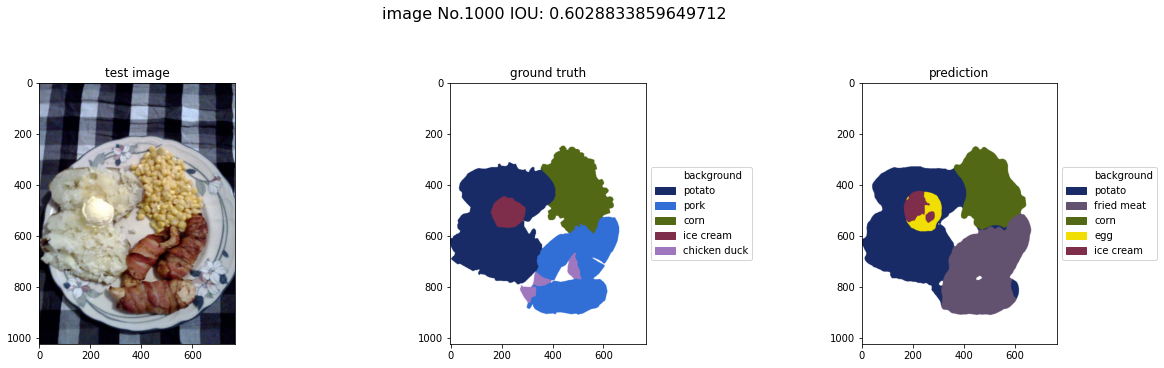

In [ ]:
BEiT.visualization.predictTestSetAndVisualize(indices=[1000])

In [ ]:
BEiT.visualization.predictTestSetAndVisualize(random_n=100)

In [ ]:
# for newly trained model
# BEiT.evaluation.generateConfusionMatrix() 

  0%|          | 0/2135 [00:00<?, ?it/s]

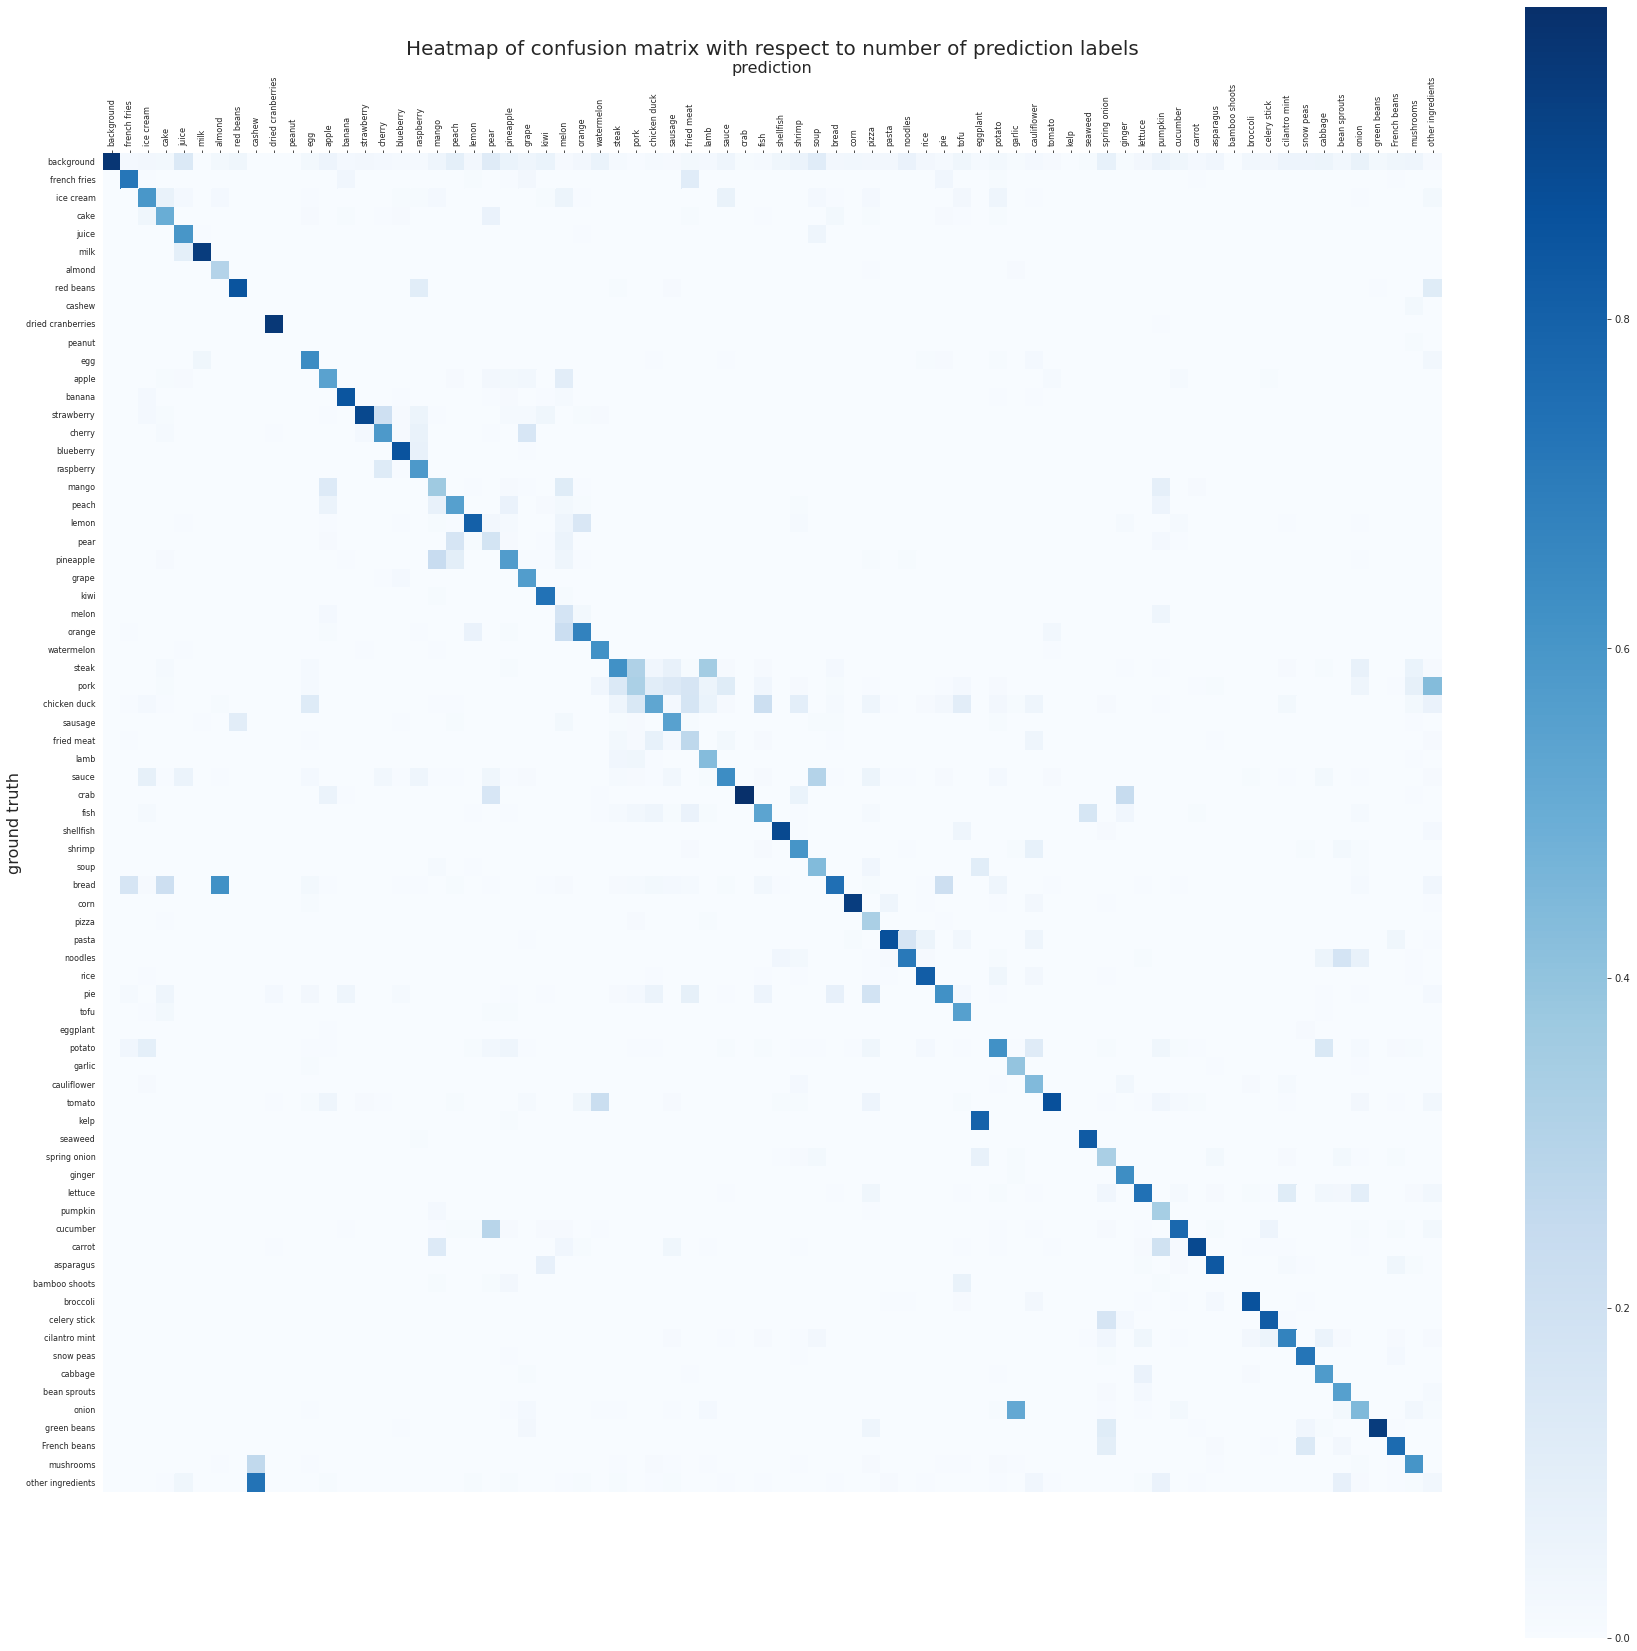

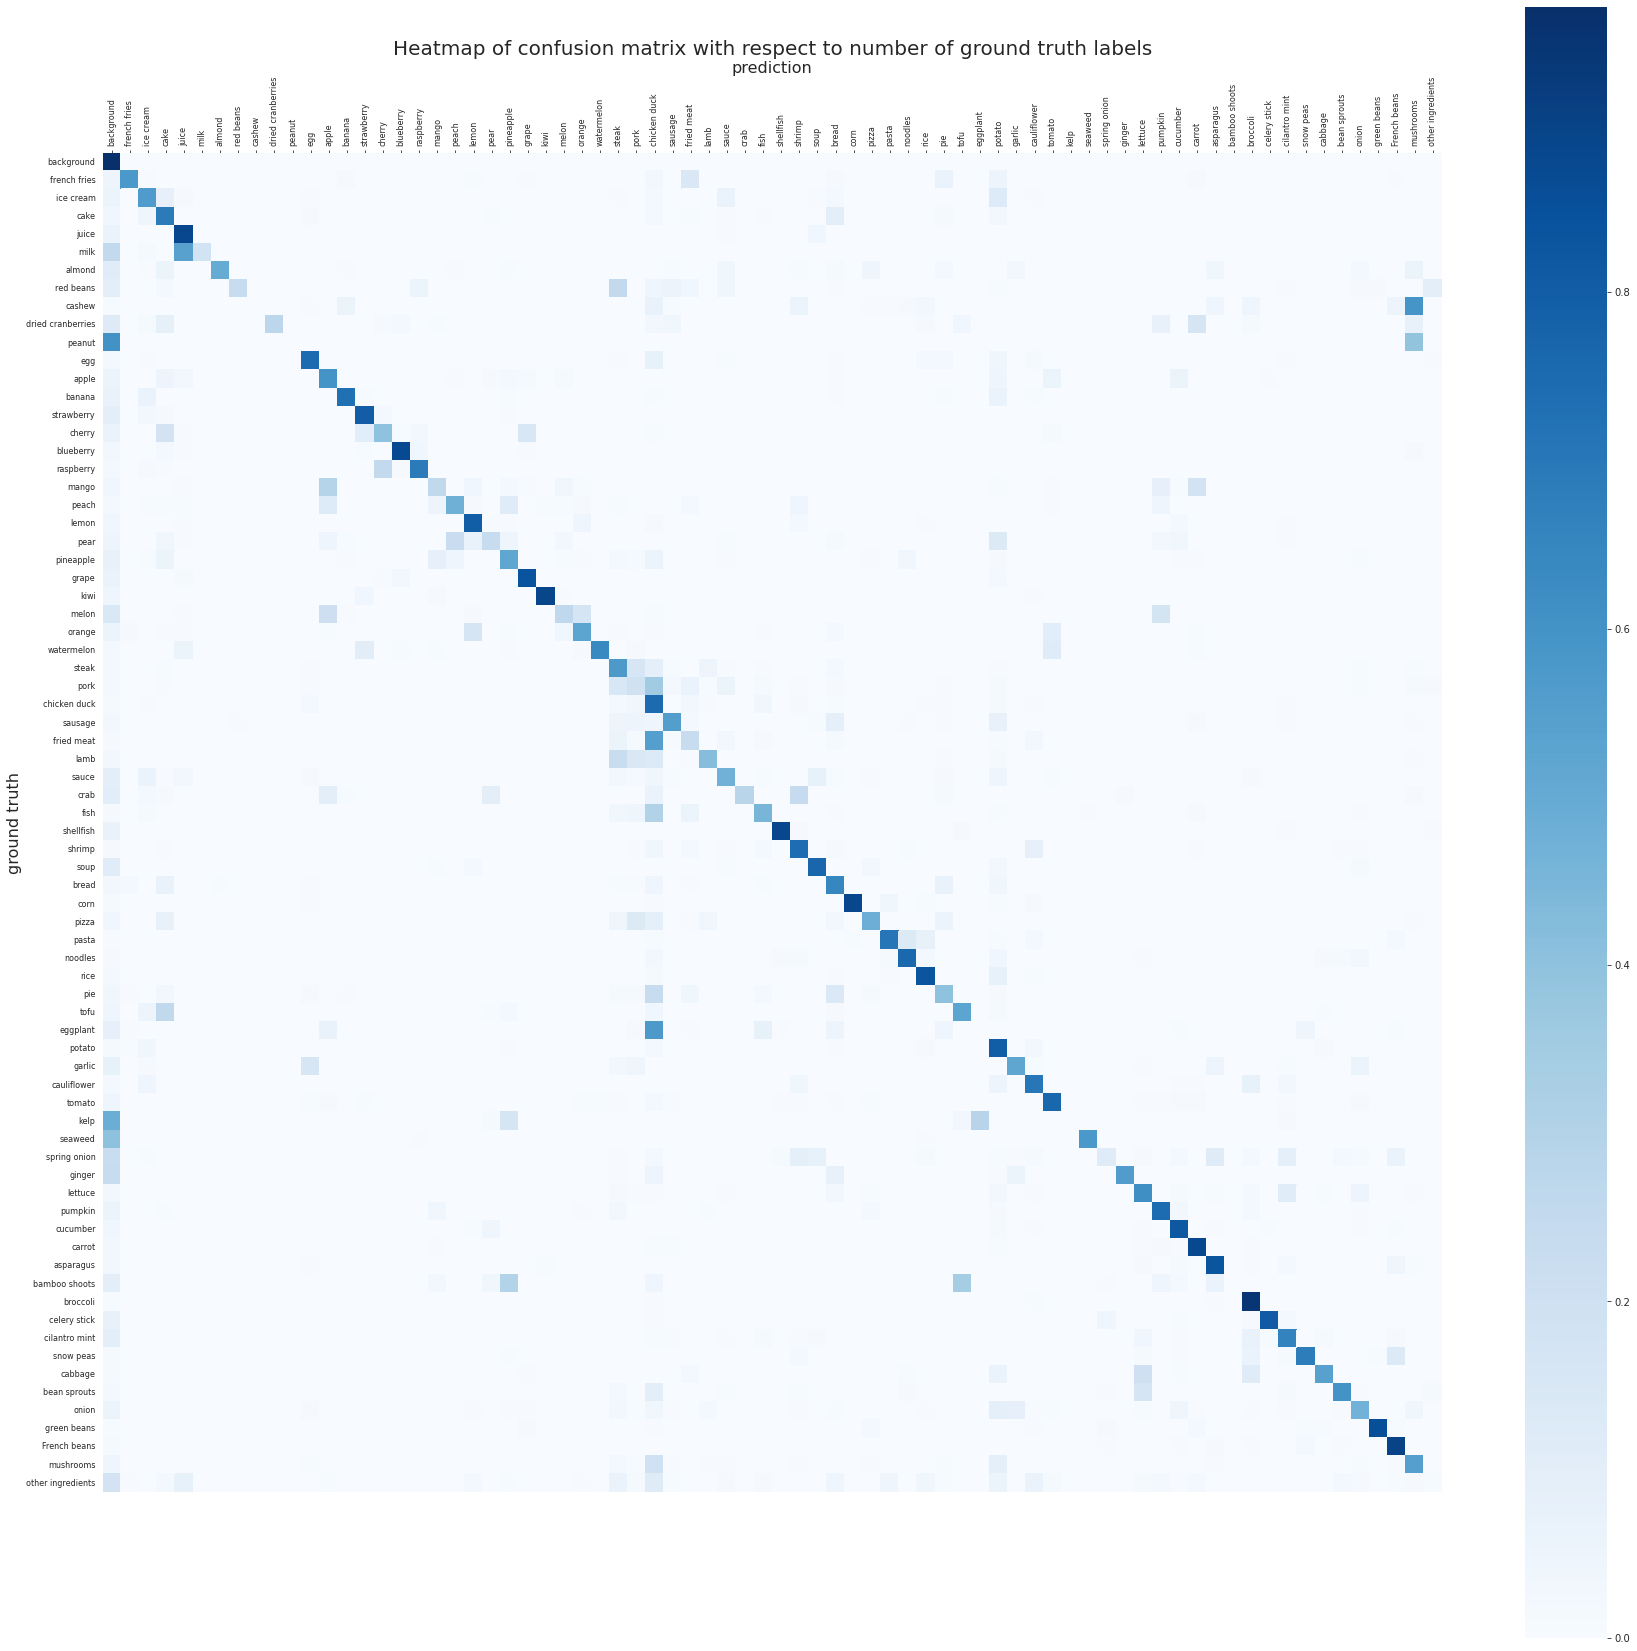

In [ ]:
BEiT.visualization.plotHeatMapOfConfusionMatrix()

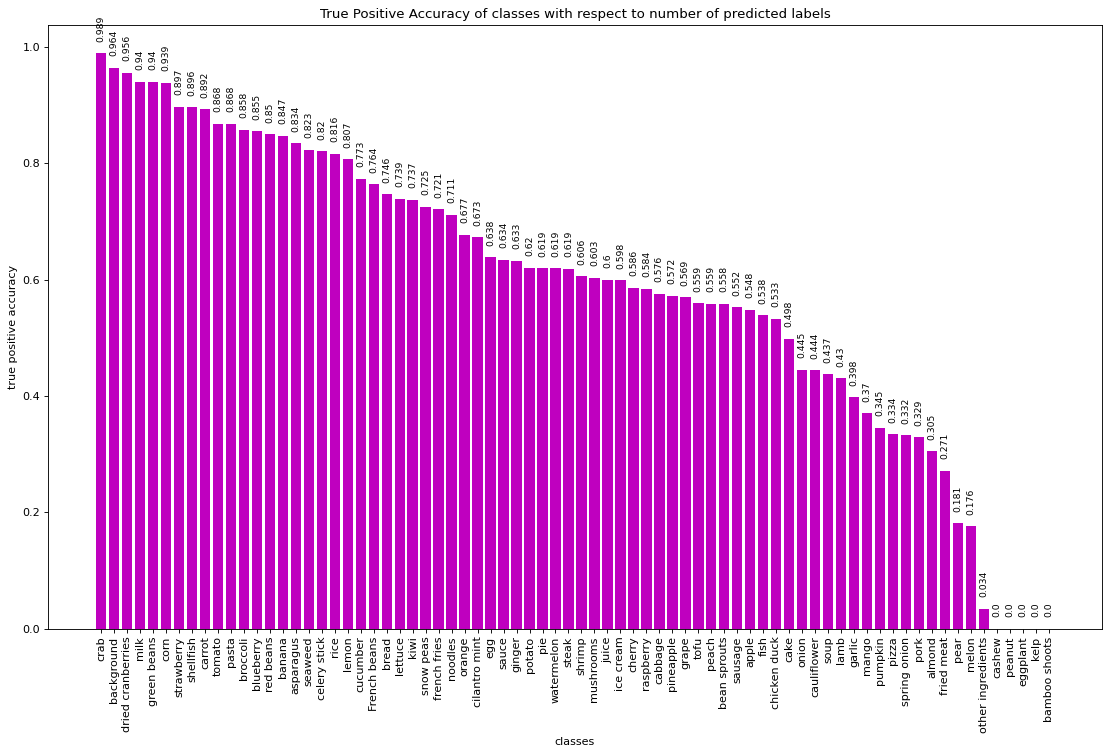

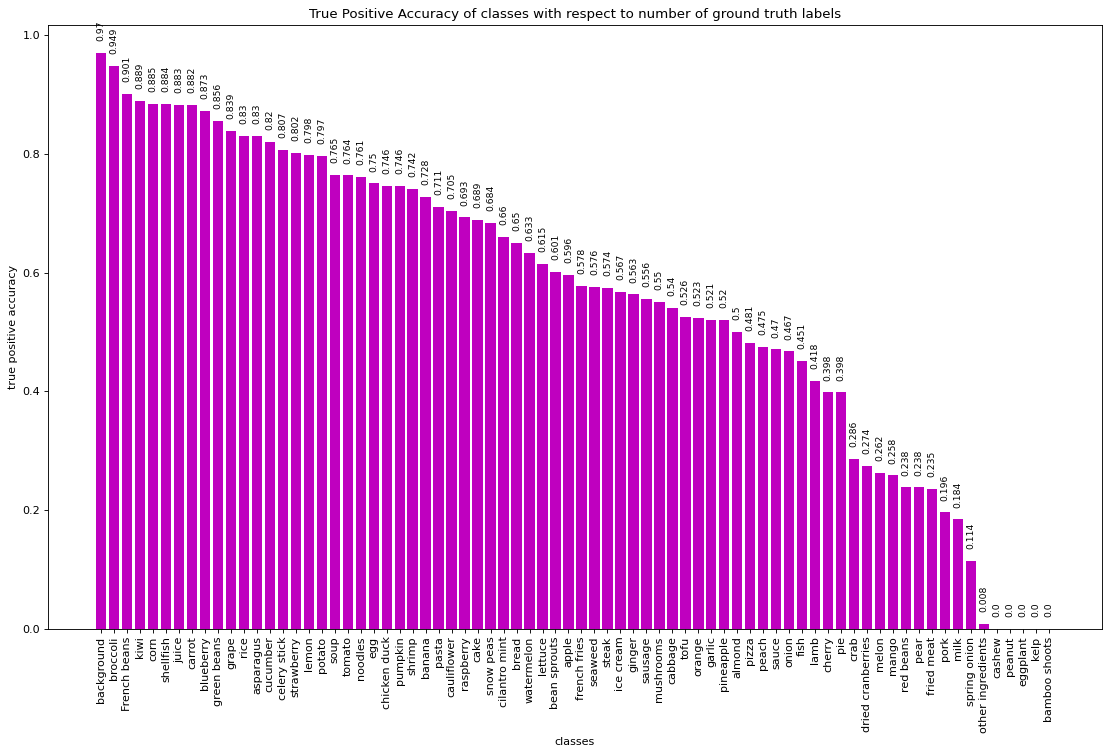

In [ ]:
BEiT.visualization.plotTruePositiveClassAccuracy()

In [ ]:
#BEiT.visualization.plotCorrespondingClassNumPics()

ValueError: ignored

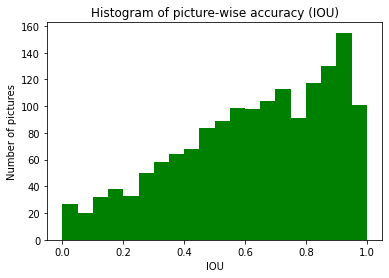

In [ ]:
BEiT.visualization.plotAccuracies()

### SegFormer

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
feature_extractor = SegformerFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
dataset, dataset_test, train_loader, validation_loader, test_loader = create_datasets(feature_extractor=feature_extractor)

In [ ]:
class SegFormerSegmentationTrainWrapper(SegmentationTrainWrapper):
  def __init__(self, feature_extractor, train_loader, validation_loader, test_loader, dataset_test, store_root_path):
    self.model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512", ignore_mismatched_sizes=True, num_labels=104, id2label=utils.id2label, label2id=utils.label2id)
    self.feature_extractor = SegformerFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
    self.model_path = f"{shared_drive_path}/{store_root_path}/state_dict/SegFormerSegmentation_best.pth"
    self.tensorboard_path = f"{shared_drive_path}/{store_root_path}/tensorboard_logs/"
    self.confusionMatrixPath = f"{shared_drive_path}/{store_root_path}/confusionMatrix1.csv"
    self.accuraciesPath = f"{shared_drive_path}/{store_root_path}/accuracies1.pickle"
    self.iterationPath = f"{shared_drive_path}/{store_root_path}/iterations.txt"
    super().__init__(feature_extractor, train_loader, validation_loader, test_loader, dataset_test)

  # override
  def freezeModelLayer(self):
    pass
    # firstLayer = next(self.model.children())
    # for param in firstLayer.parameters():
    #     param.requires_grad = False
    # print("Freezed SegFormerModel's weights")
  
  def forwardForFineTune(self, pixel_values, labels=None):
    return self.model(pixel_values=pixel_values, labels=labels)
  
  def predict(self, img, filter_small_classes=False):
    inputs = self.feature_extractor(img, return_tensors='pt')
    pixel_values = [v.numpy() for v in inputs['pixel_values']]
    pixel_values = torch.tensor(pixel_values)
    pixel_values = pixel_values.to(self.device)
    outputs = self.model(pixel_values)
    # interpolate the result to the real image's size
    upsampled_logits = nn.functional.interpolate(outputs.logits, size=(img.size[1],img.size[0]), mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)
    predicted = predicted[0].cpu().numpy().astype(np.uint8)
    if filter_small_classes:
      predicted_areas_map = []
      predicted_areas = []
      labels = np.unique(predicted)
      for l in labels:
        count = np.count_nonzero(predicted==l)
        predicted_areas_map.append((l,count))
        predicted_areas.append(count)
      max_areas = np.max(predicted_areas)
      for l, a in predicted_areas_map:
        if a < max_areas / 100:
          predicted[predicted==l] = 0
    return predicted


#### instantiate the wrapper

In [ ]:
store_root_path = "models/Segmentation/SegFormer-B4"
SegFormer = SegFormerSegmentationTrainWrapper(feature_extractor, train_loader, validation_loader, test_loader, dataset_test, store_root_path)

Downloading:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([104, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([104]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No pickle file for confusion matrix
no accuracies file found
Evaluation class initialized
no confusion matrix found, function calculateColumnsAndValuesSortedByTruePositives not available
Visualization class initialized
current iteration: 46878
loaded the best model's state dict
total trainable parameters : 64073000


In [ ]:
# SegFormer.resetIterations(0)

In [ ]:
SegFormer.setup_training(epochs=50, loss_type=SegFormer.lossHandler.types.DEFAULT)
SegFormer.finetune(test=False)

epochs set to 50
using loss 'DEFAULT' with default arguments
Generating the previous highest accuracy.


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/2135 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-52ed47aaee61>", line 2, in <module>
    SegFormer.finetune(test=False)
  File "<ipython-input-26-a37cdbe0dd2a>", line 67, in finetune
    self.highest_accuracy, _ = self.evaluation.evaluate_on_test_dataset() # generate the previous highest accuracy.
  File "<ipython-input-19-9023ec2e1cfb>", line 49, in evaluate_on_test_dataset
    predicted = self.segmenter.predict(img)
  File "<ipython-input-28-44b021a70789>", line 23, in predict
    pixel_values = torch.tensor(pixel_values)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInte

KeyboardInterrupt: ignored

In [ ]:
SegFormer.postTraining()

current iteration: 46878
loaded the best model's state dict


  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.6034379836469526
0.6034379836469526
Saved Accuracies array


  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU:  0.3307514222946838
mAcc:  0.45188483480393515


In [ ]:
mIOU, mAcc = SegFormer.evaluation.evaluate_on_test_dataset()

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5371771034984756


In [ ]:
# SegFormer.evaluation.saveAccuraciesArray()

Saved Accuracies array


In [ ]:
SegFormer.evaluation.generateConfusionMatrix()

  0%|          | 0/2135 [00:00<?, ?it/s]

In [ ]:
SegFormer.evaluation.calculatemIOUAndmAcc()

mIOU:  0.27535990790849446
mAcc:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


#### finetune the model

In [ ]:
SegFormer.setup_training(epochs=60)

epochs set to 60


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# only for start new training
# SegFormer.resetIterations(0)

In [ ]:
SegFormer.finetune()

Generating the previous highest accuracy.


  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.0037368683369764714
Epoch: 0


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.3430844318198805
New highest accuracy achieved at 0.3430844318198805 (previous: 0.0037368683369764714)
Saved the highest-accuracy model's state dict
Epoch: 1


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.3934559452162654
New highest accuracy achieved at 0.3934559452162654 (previous: 0.3430844318198805)
Saved the highest-accuracy model's state dict
Epoch: 2


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.4316044311814653
New highest accuracy achieved at 0.4316044311814653 (previous: 0.3934559452162654)
Saved the highest-accuracy model's state dict
Epoch: 3


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.4662020735592652
New highest accuracy achieved at 0.4662020735592652 (previous: 0.4316044311814653)
Saved the highest-accuracy model's state dict
Epoch: 4


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.4832876776161102
New highest accuracy achieved at 0.4832876776161102 (previous: 0.4662020735592652)
Saved the highest-accuracy model's state dict
Epoch: 5


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.48823056507238455
New highest accuracy achieved at 0.48823056507238455 (previous: 0.4832876776161102)
Saved the highest-accuracy model's state dict
Epoch: 6


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.49185895098019095
New highest accuracy achieved at 0.49185895098019095 (previous: 0.48823056507238455)
Saved the highest-accuracy model's state dict
Epoch: 7


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5110004540271296
New highest accuracy achieved at 0.5110004540271296 (previous: 0.49185895098019095)
Saved the highest-accuracy model's state dict
Epoch: 8


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.49861465490223644
Epoch: 9


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5136933918887543
New highest accuracy achieved at 0.5136933918887543 (previous: 0.5110004540271296)
Saved the highest-accuracy model's state dict
Epoch: 10


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.4989672308539522
Epoch: 11


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5039910924393157
Epoch: 12


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5046655846589746
Epoch: 13


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5083283987773629
Epoch: 14


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.49981420645300106
Epoch: 15


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5014530795463183
Epoch: 16


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.521352103390704
New highest accuracy achieved at 0.521352103390704 (previous: 0.5136933918887543)
Saved the highest-accuracy model's state dict
Epoch: 17


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.528532118531148
New highest accuracy achieved at 0.528532118531148 (previous: 0.521352103390704)
Saved the highest-accuracy model's state dict
Epoch: 18


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.4886162223572518
Epoch: 19


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5178226798350066
Epoch: 20


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5210523658907725
Epoch: 21


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5156624584890641
Epoch: 22


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5132795729817166
Epoch: 23


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.493547186448148
Epoch: 24


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5212028698066117
Epoch: 25


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5273606000508062
Epoch: 26


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5211494384682
Epoch: 27


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5148873139977137
Epoch: 28


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5228660965219736
Epoch: 29


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5211223816711585
Epoch: 30


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5258468110453689
Epoch: 31


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5139865763044427
Epoch: 32


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5240617493215303
Epoch: 33


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5247978637428724
Epoch: 34


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5171998091486448
Epoch: 35


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.524228236363765
Epoch: 36


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5264151304821647
Epoch: 37


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5266686066446234
Epoch: 38


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5317862704908196
New highest accuracy achieved at 0.5317862704908196 (previous: 0.528532118531148)
Saved the highest-accuracy model's state dict
Epoch: 39


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5234323554199463
Epoch: 40


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5224153436674956
Epoch: 41


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5354598914818348
New highest accuracy achieved at 0.5354598914818348 (previous: 0.5317862704908196)
Saved the highest-accuracy model's state dict
Epoch: 42


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5282294296711932
Epoch: 43


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5303609067567079
Epoch: 44


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5268833985406349
Epoch: 45


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5275245711929059
Epoch: 46


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5276389516142045
Epoch: 47


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5250287966236135
Epoch: 48


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5325724934480346
Epoch: 49


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5371771271577345
New highest accuracy achieved at 0.5371771271577345 (previous: 0.5354598914818348)
Saved the highest-accuracy model's state dict
Epoch: 50


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5262168781136701
Epoch: 51


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5335939531571204
Epoch: 52


  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/2135 [00:00<?, ?it/s]

mIOU: 0.5363683206050366
Epoch: 53


  0%|          | 0/2341 [00:00<?, ?it/s]

#### evaluate the model

In [ ]:
SegFormer.evaluation.evaluate()

NameError: ignored

In [ ]:
mIOU, accuracies = SegFormer.evaluation.evaluate_on_test_dataset()

In [ ]:
# for newly trained model
# SegFormer.evaluation.saveAccuraciesArray()

In [ ]:
# for newly trained model
# SegFormer.evaluation.generateConfusionMatrix()

#### visualize the results

In [ ]:
SegFormer.visualization.predictTestSetAndVisualize(indices=[1875, 1818, 406, 761, 1041, 769])

In [ ]:
SegFormer.visualization.predictTestSetAndVisualize(random_n=2135)

In [ ]:
# for newly trained model
# SegFormer.calculateTwoConfusionMatrix()
SegFormer.visualization.plotHeatMapOfConfusionMatrix()

In [ ]:
SegFormer.visualization.plotTruePositiveClassAccuracy()

In [ ]:
SegFormer.visualization.plotCorrespondingClassNumPics()

In [ ]:
SegFormer.visualization.plotAccuracies()

### SETR_MLA

In [ ]:
!git clone https://github.com/KombangkoeDias/CapstoneFinal.git

Cloning into 'CapstoneFinal'...
remote: Enumerating objects: 1161, done.
remote: Counting objects: 100% (1161/1161), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 1161 (delta 609), reused 1104 (delta 552), pack-reused 0
Receiving objects: 100% (1161/1161), 5.73 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (609/609), done.


In [ ]:
%cd /content/CapstoneFinal/SETR_MLA

/content/CapstoneFinal/SETR_MLA


In [ ]:
!pip install -e .

Obtaining file:///content/CapstoneFinal/SETR_MLA
  Running setup.py develop for mmsegmentation


In [ ]:
%cd /content
!python mmdeploy/tools/deploy.py \
    mmdeploy/configs/mmseg/segmentation_onnxruntime_dynamic.py \
    '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original/SETR_MLA_768x768_80k_base.py' \
    '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original/iter_80000.pth' \
    /content/FoodSeg103/Images/img_dir/train/00000000.jpg \
    --work-dir '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original' \
    --show

/content
2022-04-16 03:44:36,361 - mmdeploy - INFO - torch2onnx start.
2022-04-16:03:44:43,numexpr.utils INFO     [utils.py:159] NumExpr defaulting to 4 threads.
/content/CapstoneFinal/SETR_MLA/mmseg/models/builder.py:61: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)
load pre-trained weight from imagenet21k
load checkpoint from local path: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original/iter_80000.pth
2022-04-16 03:44:47,320 - mmdeploy - WARNING - DeprecationWarning: get_onnx_config will be deprecated in the future. 
2022-04-16:03:44:47,mmdeploy WARNING  [utils.py:92] DeprecationWarning: get_onnx_config will be deprecated in the future. 
2022-04-16 03:44:47,327 - mmdeploy - WARNING - Can not find mmseg.models.segmentors.BaseSegmentor.forward, function rewrite will not be applied
2022-04-16:03:44:47,mmdeploy WARNING  [function_rewriter.py:110] Can not find mmseg.models.segmen

In [ ]:
import torch, torchvision
# Check MMSegmentation installation
import mmseg
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmcv import Config

In [ ]:
dataset, dataset_test, train_loader, validation_loader, test_loader = create_datasets(root_path_image=f"{data_path}/Images",feature_extractor=None)

In [ ]:
SETR_MLA_path = f"{shared_drive_path}/models/Segmentation/SETR_MLA"
config_file = f"{SETR_MLA_path}/Original/SETR_MLA_768x768_80k_base.py"
#config_file = f"{SETR_MLA_path}/reproduce_80000/config.py"
checkpoint_file = f"{SETR_MLA_path}/Original/iter_80000.pth"

In [ ]:
class SETR_MLATrainWrapper(SegmentationTrainWrapper):
  def __init__(self, feature_extractor, train_loader, validation_loader, test_loader, dataset_test, store_root_path, checkpoint_file):
    self.model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
    self.model.config = config
    # if self.model.config.num_labels != 104:
    #   self.model.decode_head.cls = nn.Conv2d(512, config.num_labels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    #   for aux_head in SETR_MLA.model.auxiliary_head:
    #     aux_head.aux = nn.Conv2d(256, config.num_labels, kernel_size=(1, 1), stride=(1, 1), bias=False)
    self.cfg = Config.fromfile(config_file)
    self.feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
    self.model_path = checkpoint_file
    self.tensorboard_path = f"{shared_drive_path}/{store_root_path}/tensorboard_logs/"
    self.confusionMatrixPath = f"{shared_drive_path}/{store_root_path}/confusionMatrix1.csv"
    self.accuraciesPath = f"{shared_drive_path}/{store_root_path}/accuracies1.pickle"
    self.iterationPath = f"{shared_drive_path}/{store_root_path}/iterations.txt"
    super().__init__(feature_extractor, train_loader, validation_loader, test_loader, dataset_test, 'img_path')
  
  # override
  def freezeModelLayer(self):
    pass
    # firstLayer = next(self.model.children())
    # for param in firstLayer.parameters():
    #     param.requires_grad = False
    # print("Freezed SegFormerModel's weights")
  
  def forwardForFineTune(self, pixel_values, labels=None):
    return np.array(inference_segmentor(self.model, img))
  
  def predict(self, img, filter_small_classes=False):
    predicted = inference_segmentor(self.model, img)
    return np.array(predicted).astype(np.uint8)[0,:,:]


#### initialize the wrapper

In [ ]:
store_root_path = "models/Segmentation/SETR_MLA/reproduce_80000"

SETR_MLA = SETR_MLATrainWrapper(None, train_loader, validation_loader, test_loader, dataset_test, store_root_path,checkpoint_file)

/content/CapstoneFinal/mmseg/models/builder.py:61: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


load pre-trained weight from imagenet21k
load checkpoint from local path: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/reproduce_80000/iter_80000.pth
No pickle file for confusion matrix
no accuracies file found
Evaluation class initialized
no confusion matrix found, function calculateColumnsAndValuesSortedByTruePositives not available
Visualization class initialized
using the default Model because [Errno 2] No such file or directory: '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/reproduce_80000/iterations.txt'
total trainable parameters : 93196144


In [ ]:
SETR_MLA.postTraining()

using the default Model because [Errno 2] No such file or directory: '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/reproduce_80000/iterations.txt'


100%|██████████| 2135/2135 [53:25<00:00,  1.50s/it, accuracy=0.0767]

mIOU: 0.5662135030939216
Saved Accuracies array
mIOU:  0.27522710172864134
mAcc:  0.37773340483235585


(0.27522710172864134, 0.37773340483235585)

#### fine-tune the model

In [ ]:
from mmcv import Config
cfg = Config.fromfile(config_file)
cfg.dataset_type = 'FoodSeg103Dataset'
cfg.data.train['type'] = 'FoodSeg103Dataset'
cfg.data.val['type'] = 'FoodSeg103Dataset'
cfg.data.test['type'] = 'FoodSeg103Dataset'
cfg.data.test['data_root'] = '/content/FoodSeg103/Images'
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.evaluation = dict(interval=5000, metric='mIoU')
cfg.resume_from = f"{shared_drive_path}/{store_root_path}/iter_50000.pth"
cfg.runner.max_iters = 80000
cfg.work_dir=f"{shared_drive_path}/{store_root_path}"
cfg.data_root = '/content/FoodSeg103/Images/'
cfg.data.train.data_root= cfg.data_root
cfg.data.val.data_root = cfg.data_root
cfg.data.test.data_root = cfg.data_root
cfg.checkpoint_config = dict(by_epoch=False, interval=10000)
cfg.seed = 42

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    backbone=dict(
        type='VIT_MLA',
        model_name='vit_base_patch16_224',
        img_size=768,
        patch_size=16,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        num_classes=19,
        drop_rate=0.0,
        norm_cfg=dict(type='BN', requires_grad=True),
        pos_embed_interp=True,
        align_corners=False,
        mla_channels=256,
        mla_index=(5, 7, 9, 11)),
    decode_head=dict(
        type='VIT_MLAHead',
        in_channels=1024,
        channels=512,
        img_size=768,
        mla_channels=256,
        mlahead_channels=128,
        num_classes=104,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=[
        dict(
            type='VIT_MLA_AUXIHead',
            

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import numpy as np

try:
  @DATASETS.register_module()
  class FoodSeg103Dataset(CustomDataset):
    CLASSES = tuple(utils.id2label.values())
    palettes = [[255,255,255]]
    for i in range(len(utils.id2label.keys())):
        palette = list(np.random.choice(range(1,255), size=3, replace=False))
        palettes.append(palette)
    PALETTE = palettes
    def __init__(self, **kwargs):
      super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
except Exception as e:
  print(e)

In [ ]:
datasets = [build_dataset(cfg.data.train)]

2022-04-09 10:18:22,402 - mmseg - INFO - Loaded 4983 images


In [ ]:
# with open(f"{shared_drive_path}/{store_root_path}/config.py", 'w') as f:
#   f.write(cfg.pretty_text)

In [ ]:
import mmcv
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [ ]:
model = build_segmentor(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

/content/CapstoneFinal/mmseg/models/builder.py:61: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


load pre-trained weight from imagenet21k


In [ ]:
train_segmentor(model, datasets, cfg, distributed=False, validate=False, 
                meta=dict(CLASSES=datasets[0].CLASSES, PALETTE=datasets[0].PALETTE))

2022-04-09 10:19:00,699 - mmseg - INFO - load checkpoint from local path: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/reproduce_80000/iter_50000.pth
2022-04-09 10:19:28,892 - mmseg - INFO - resumed from epoch: 11, iter 49999
2022-04-09 10:19:28,894 - mmseg - INFO - Start running, host: root@af7bb383e635, work_dir: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/reproduce_80000
2022-04-09 10:19:28,896 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook

#### evaluate the model

In [ ]:
SETR_MLA_path

'/content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA'

finished
!python mmdeploy/tools/deploy.py 
    mmdeploy/configs/mmseg/segmentation_onnxruntime_dynamic.py
    /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original/SETR_MLA_768x768_80k_base.py
    /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original/iter_80000.pth 
    /content/FoodSeg103/Images/img_dir/train/00000000.jpg
    --work-dir /content/drive/Shareddrives/Food Analytic/models/Segmentation/SETR_MLA/Original 
    --show


In [ ]:
|# SETR_MLA.resetIterations(80000)

In [ ]:
SETR_MLA.postTraining()

current iteration: 80000
using the default Model because Error(s) in loading state_dict for EncoderDecoder:
	Missing key(s) in state_dict: "backbone.cls_token", "backbone.pos_embed", "backbone.patch_embed.proj.weight", "backbone.patch_embed.proj.bias", "backbone.blocks.0.norm1.weight", "backbone.blocks.0.norm1.bias", "backbone.blocks.0.attn.qkv.weight", "backbone.blocks.0.attn.qkv.bias", "backbone.blocks.0.attn.proj.weight", "backbone.blocks.0.attn.proj.bias", "backbone.blocks.0.norm2.weight", "backbone.blocks.0.norm2.bias", "backbone.blocks.0.mlp.fc1.weight", "backbone.blocks.0.mlp.fc1.bias", "backbone.blocks.0.mlp.fc2.weight", "backbone.blocks.0.mlp.fc2.bias", "backbone.blocks.1.norm1.weight", "backbone.blocks.1.norm1.bias", "backbone.blocks.1.attn.qkv.weight", "backbone.blocks.1.attn.qkv.bias", "backbone.blocks.1.attn.proj.weight", "backbone.blocks.1.attn.proj.bias", "backbone.blocks.1.norm2.weight", "backbone.blocks.1.norm2.bias", "backbone.blocks.1.mlp.fc1.weight", "backbone.block

100%|██████████| 1571/1571 [38:25<00:00,  1.47s/it, accuracy=0.481]

mIOU: 0.6396001322025137
Saved Accuracies array
mIOU:  0.4449781303965982
mAcc:  0.5971536995311314


In [ ]:
SETR_MLA.evaluation.evaluate()

NameError: ignored

In [ ]:
mIOU, accuracies = SETR_MLA.evaluation.evaluate_on_test_dataset()

In [ ]:
# for newly trained model
# SETR_MLA.evaluation.saveAccuraciesArray()

In [ ]:
# for newly trained model
# SETR_MLA.evaluation.generateConfusionMatrix()

#### visualize the results

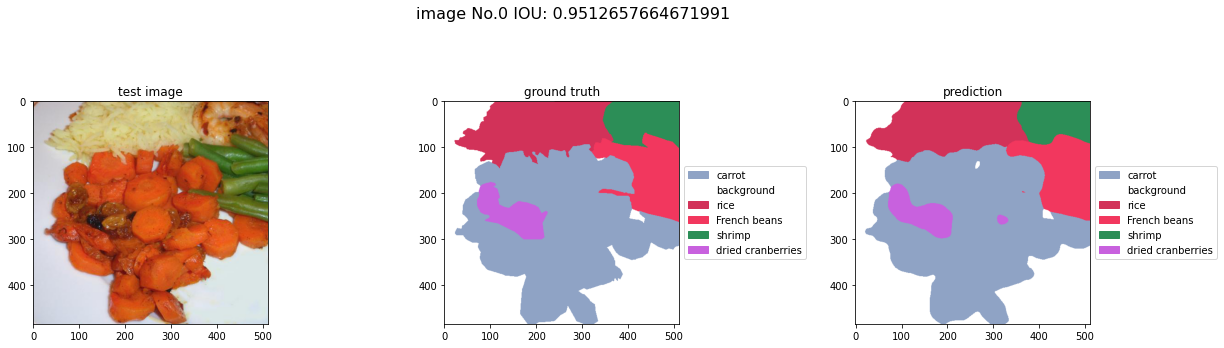

In [ ]:
SETR_MLA.visualization.predictTestSetAndVisualize(indices=[0])

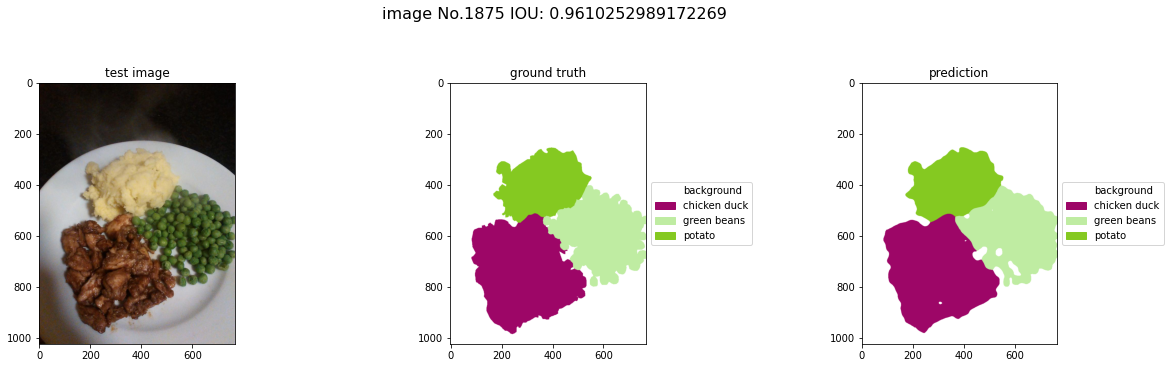

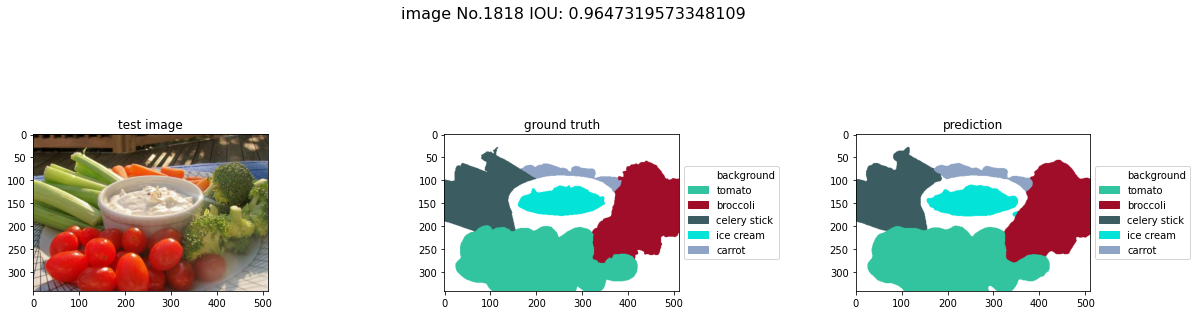

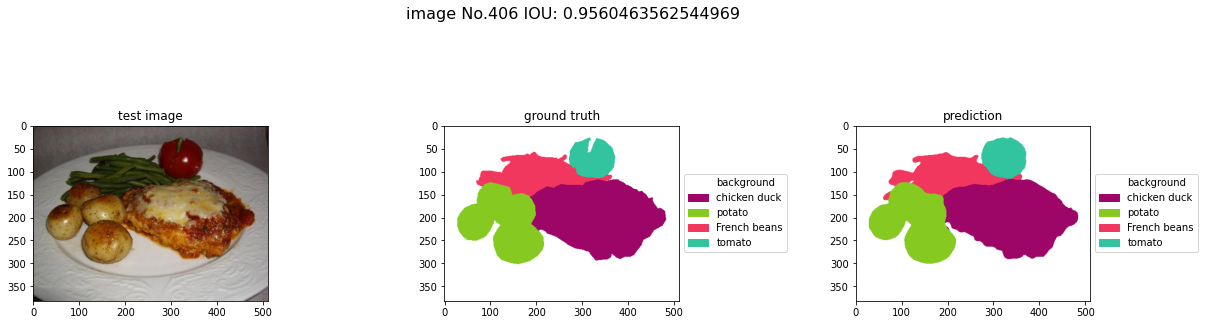

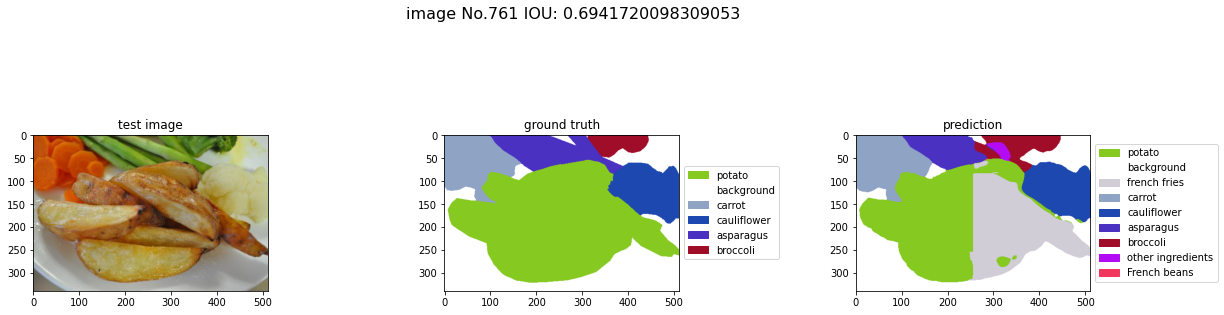

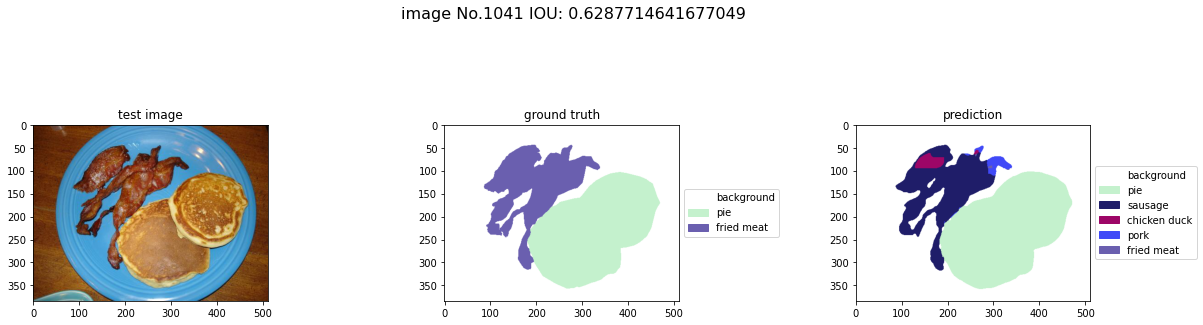

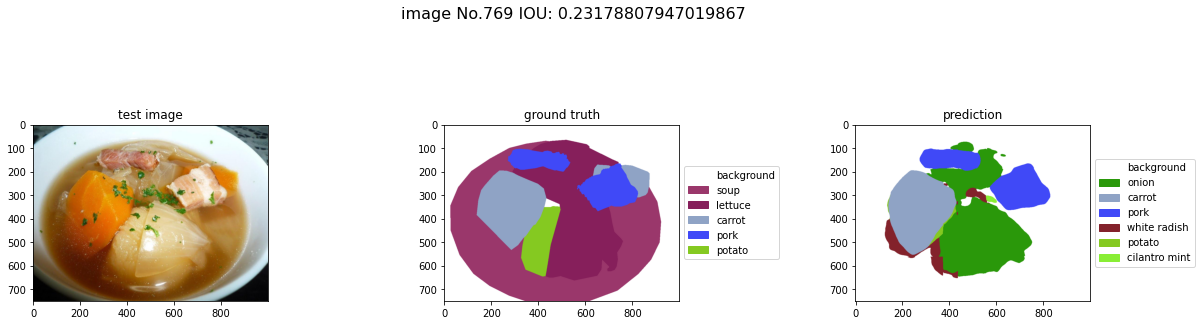

In [ ]:
SETR_MLA.visualization.predictTestSetAndVisualize(indices=[1875, 1818, 406, 761, 1041, 769])

In [ ]:
SETR_MLA.visualization.predictTestSetAndVisualize(random_n=2135)

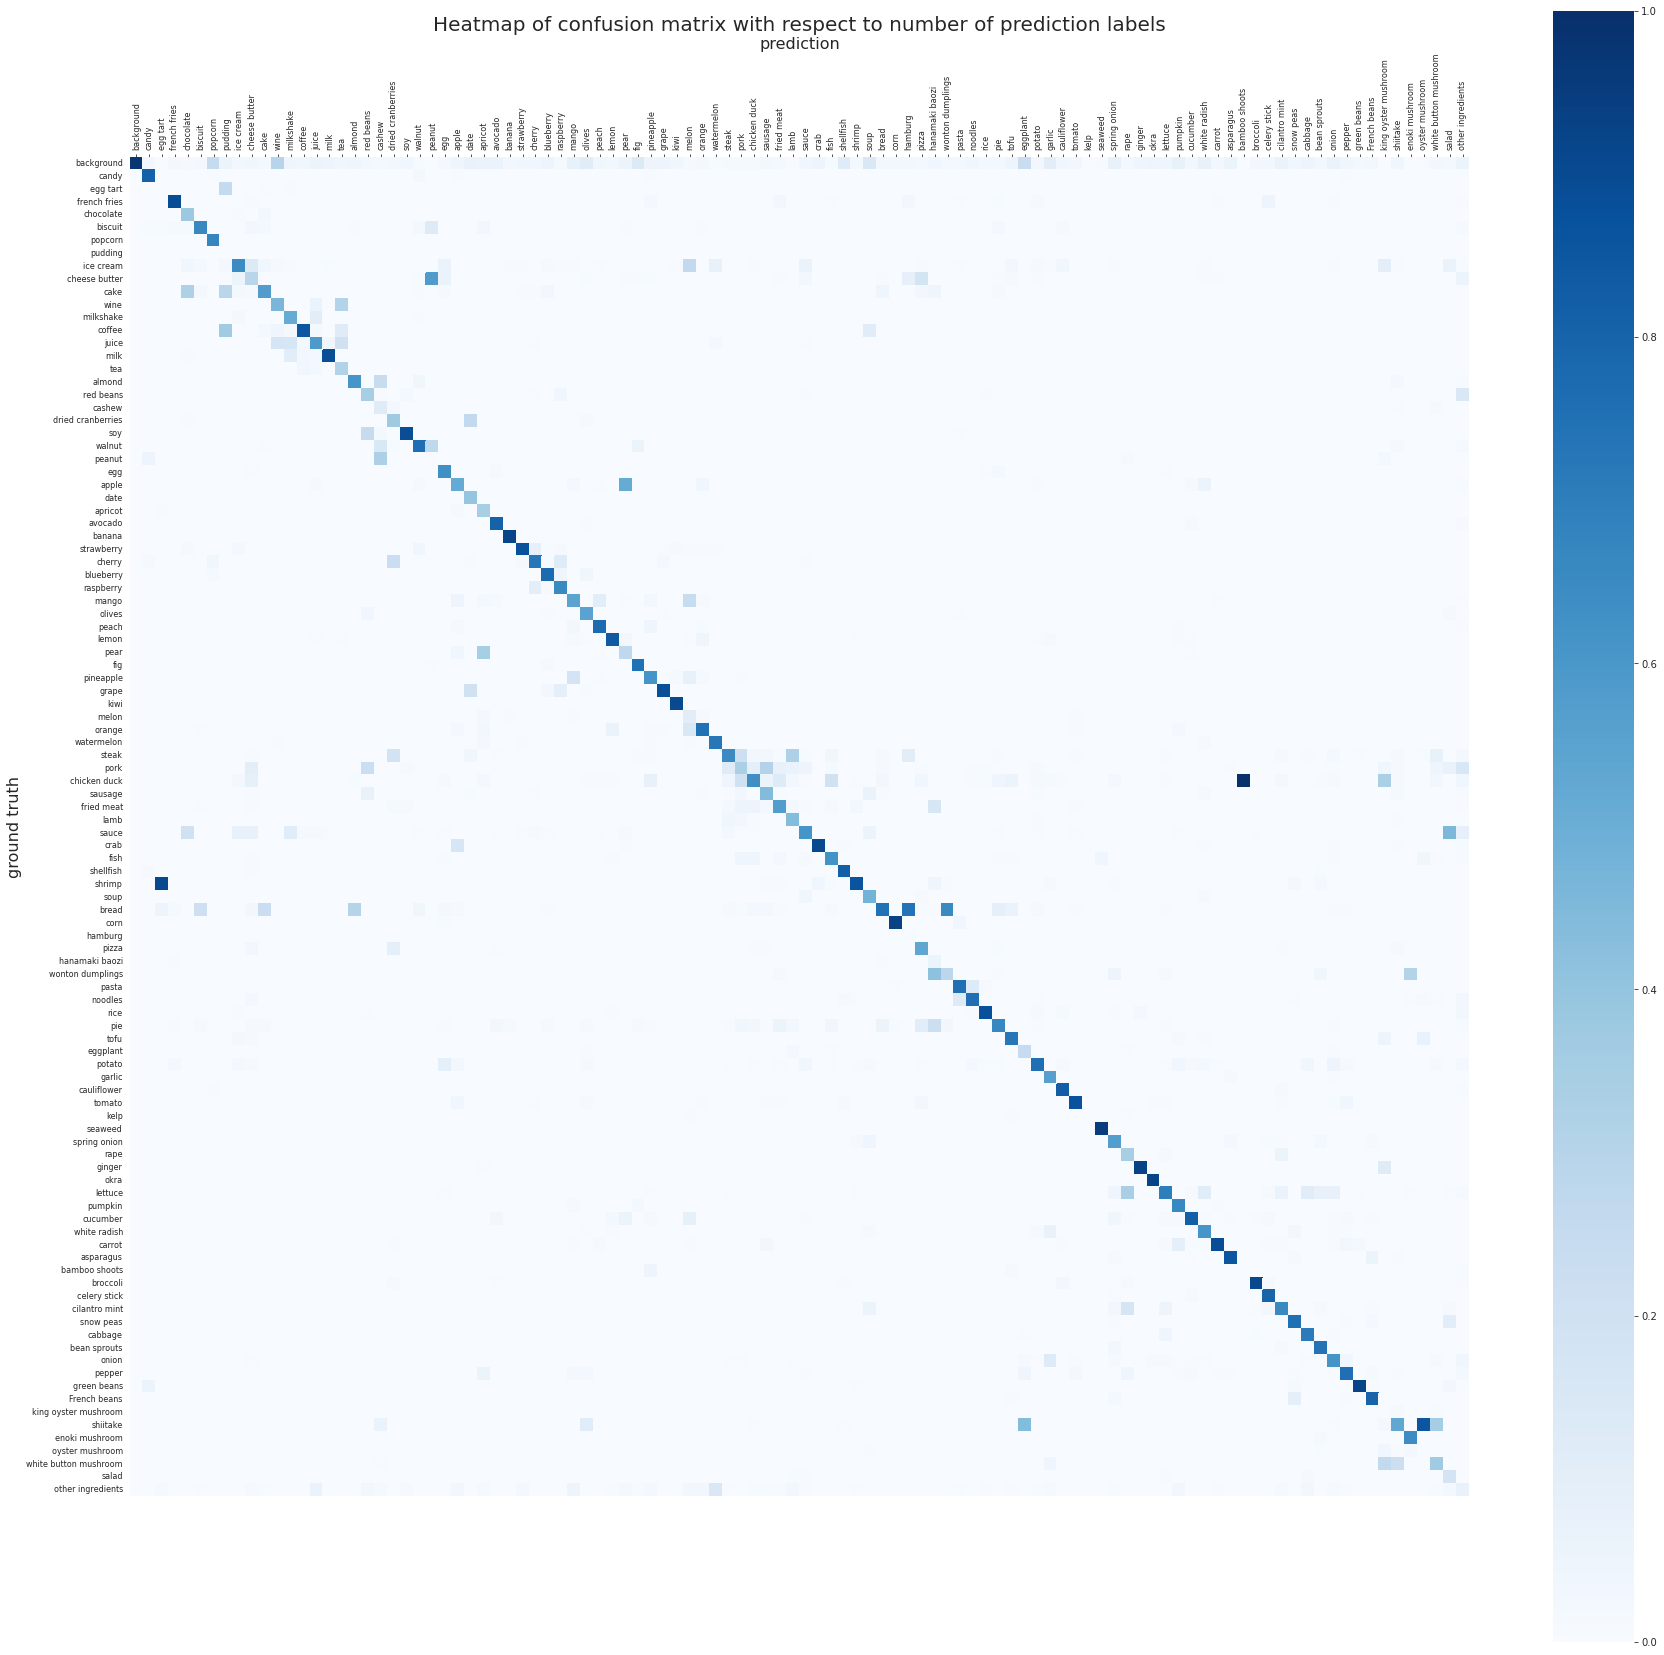

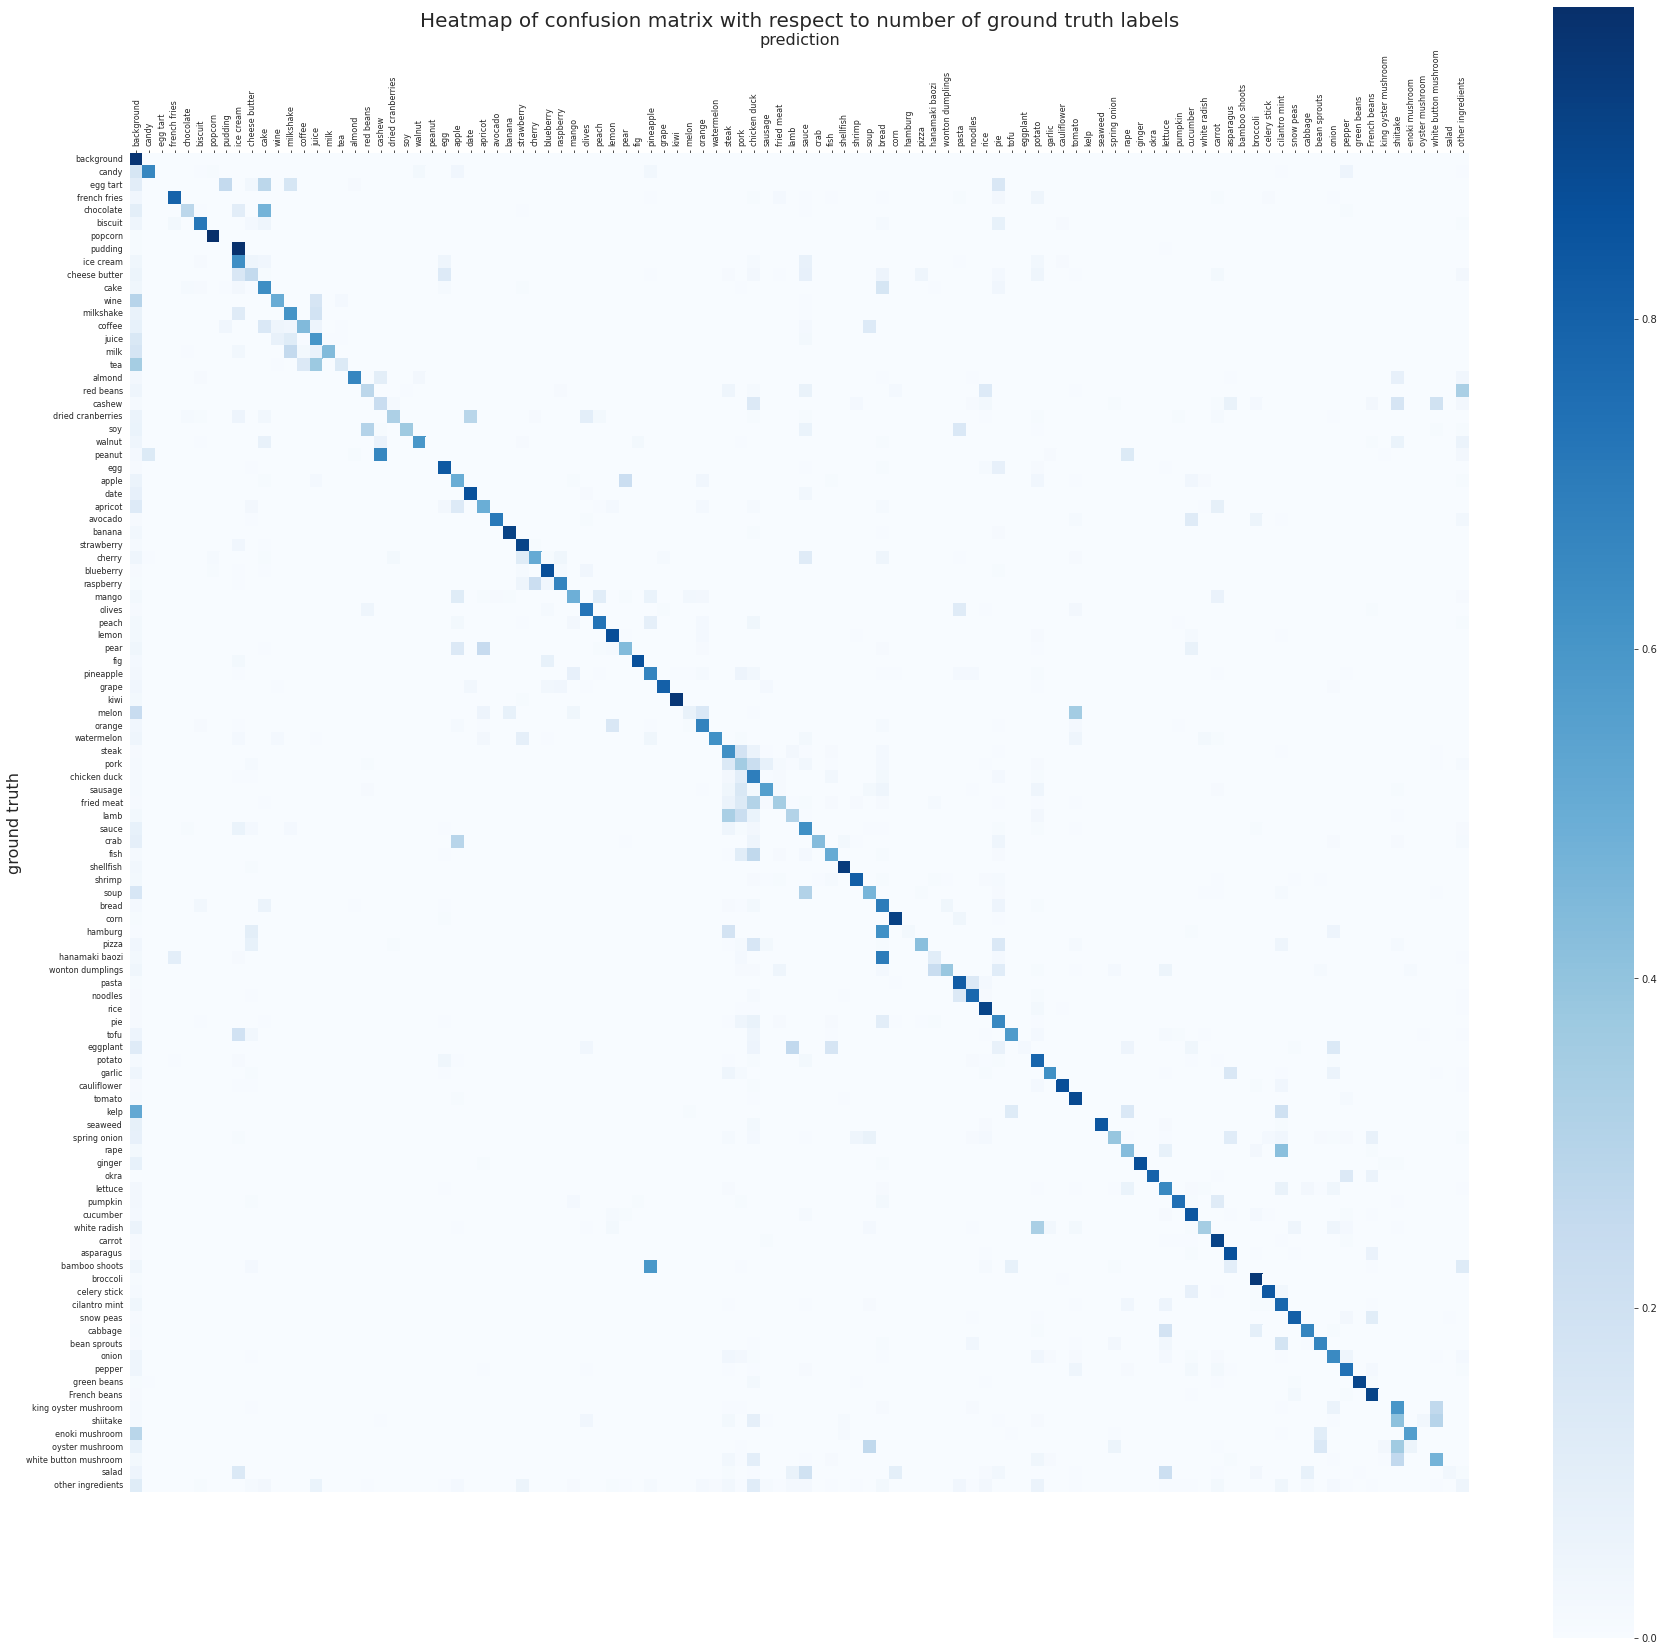

In [ ]:
# for newly trained model
SETR_MLA.visualization.plotHeatMapOfConfusionMatrix()

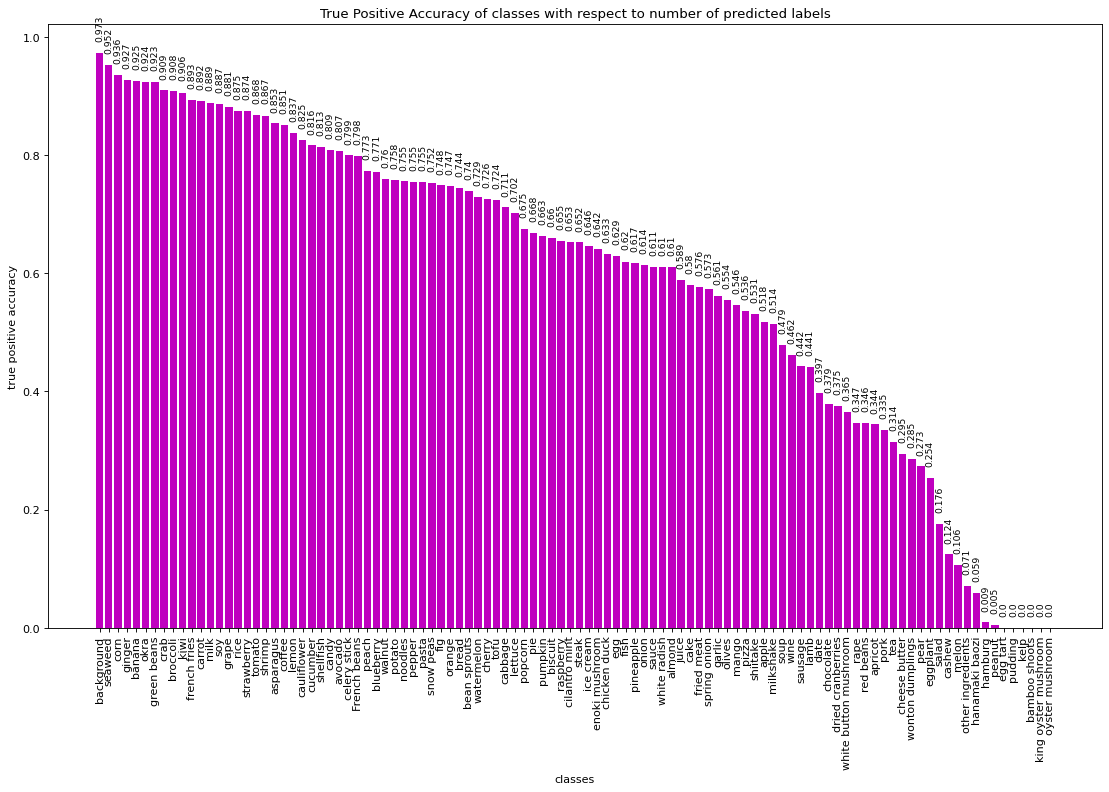

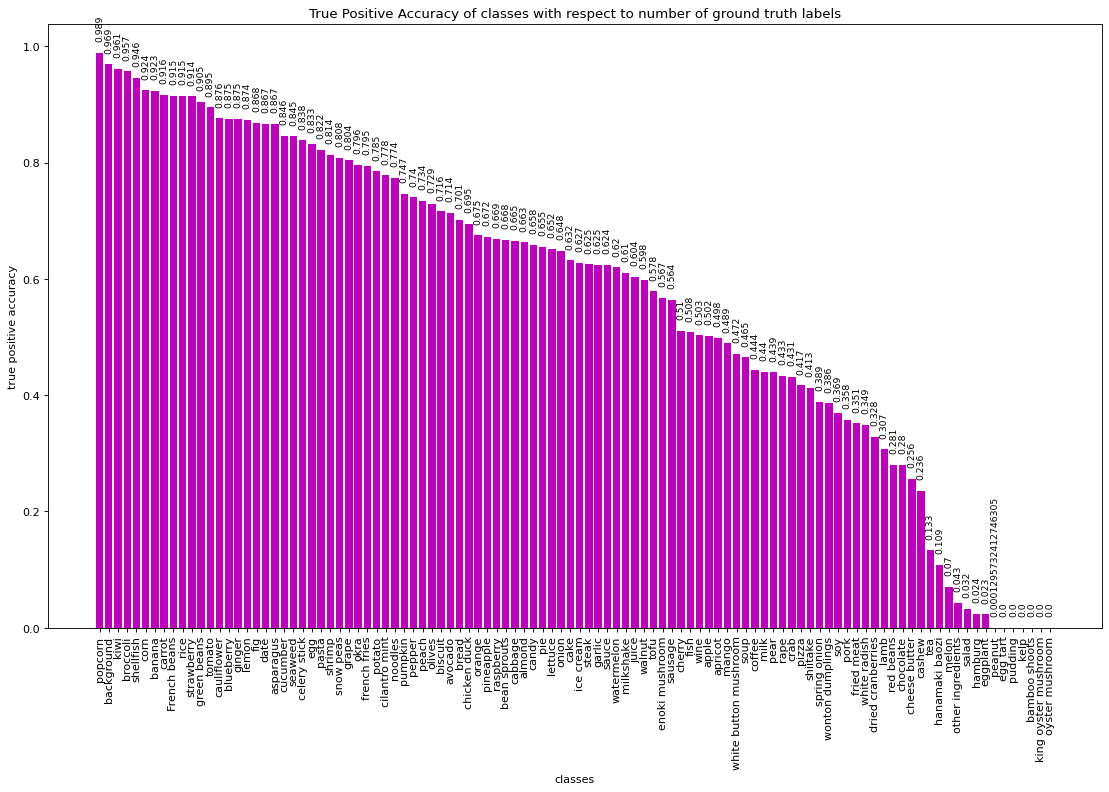

In [ ]:
SETR_MLA.visualization.plotTruePositiveClassAccuracy()

In [ ]:
SETR_MLA.visualization.plotCorrespondingClassNumPics()

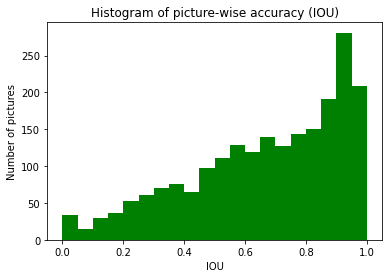

In [ ]:
SETR_MLA.visualization.plotAccuracies()

### ConvNeXt

#### install mmsegmentation

In [ ]:
%cd /content
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation

/content
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6712, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 6712 (delta 63), reused 46 (delta 12), pack-reused 6553
Receiving objects: 100% (6712/6712), 12.74 MiB | 32.62 MiB/s, done.
Resolving deltas: 100% (4945/4945), done.
/content/mmsegmentation


#### register dataset

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import numpy as np

try:
  @DATASETS.register_module()
  class FoodSeg103Dataset(CustomDataset):
    CLASSES = tuple(utils.id2label.values())
    palettes = [[255,255,255]]
    for i in range(len(utils.id2label.keys())):
        palette = list(np.random.choice(range(1,255), size=3, replace=False))
        palettes.append(palette)
    PALETTE = palette
    def __init__(self, **kwargs):
      super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
except Exception as e:
  print(e)
    

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp
import mmcv

#### set config

In [ ]:
store_path = f"{shared_drive_path}/models/Segmentation/ConvNeXt/state_dict"

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/convnext/upernet_convnext_base_fp16_640x640_160k_ade20k.py')

cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 104
cfg.model.auxiliary_head.num_classes = 104

cfg.train_cfg = cfg.model.train_cfg
del cfg.model.train_cfg
cfg.test_cfg = cfg.model.test_cfg
del cfg.model.test_cfg

cfg.dataset_type = 'FoodSeg103Dataset'
cfg.data_root = '/content/FoodSeg103/Images'
cfg.img_norm_cfg = dict(
    dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2049, 1025), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(640, 640), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(640,640), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2049, 1025),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

cfg.data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/train',
        ann_dir='ann_dir/train',
        pipeline=cfg.train_pipeline
    ),
    val=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    ),
    test=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    )
)

cfg.crop_size = (640,640)

cfg.log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])

cfg.log_level = 'INFO'
cfg.load_from = None
cfg.resume_from = None
cfg.workflow = [('train', 1)]
cfg.cudnn_benchmark = True

cfg.optimizer = dict(
    type='SGD',
    lr=0.02,
    momentum=0.9,
    weight_decay=0.0,
    paramwise_cfg=dict(custom_keys=dict(head=dict(lr_mult=10.0))))
cfg.optimizer_config = dict()
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)

cfg.runner = dict(type='IterBasedRunner', max_iters=120000)
cfg.checkpoint_config = dict(by_epoch=False, interval=5000)

cfg.evaluation = dict(interval=5000, metric='mIoU')
cfg.find_unused_parameters = True

cfg.work_dir = store_path

cfg.gpu_ids = range(0, 1)

cfg.seed = 42

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
custom_imports = dict(imports='mmcls.models', allow_failed_imports=False)
checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-base_3rdparty_in21k_20220301-262fd037.pth'
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='mmcls.ConvNeXt',
        arch='base',
        out_indices=[0, 1, 2, 3],
        drop_path_rate=0.4,
        layer_scale_init_value=1.0,
        gap_before_final_norm=False,
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-base_3rdparty_in21k_20220301-262fd037.pth',
            prefix='backbone.'),
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
   

In [ ]:
with open(f"{cfg.work_dir}/config.py", 'w') as f:
  f.write(cfg.pretty_text)

#### build datasets

In [ ]:
datasets = [build_dataset(cfg.data.train)]

2022-04-06 09:56:54,360 - mmseg - INFO - Loaded 4983 images


#### build segmentor

In [ ]:
model = build_segmentor(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

/content/mmsegmentation/mmseg/models/builder.py:43: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:226: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


#### fine tune


In [ ]:
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [ ]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict(CLASSES=datasets[0].CLASSES, PALETTE=datasets[0].PALETTE))

2022-04-06 09:57:00,682 - mmseg - INFO - Loaded 2135 images
2022-04-06 09:57:00,683 - mmseg - INFO - Start running, host: root@346c7d3bca64, work_dir: /content/drive/Shareddrives/Food Analytic/models/Segmentation/ConvNeXt/state_dict
2022-04-06 09:57:00,684 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 --------------------

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1578s, ETA:     0s

2022-04-06 11:55:22,097 - mmseg - INFO - per class results:
2022-04-06 11:55:22,105 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 51.21 | 100.0 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1578s, ETA:     0s

2022-04-06 13:54:29,138 - mmseg - INFO - per class results:
2022-04-06 13:54:29,145 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 51.21 | 100.0 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1577s, ETA:     0s

2022-04-06 15:53:51,167 - mmseg - INFO - per class results:
2022-04-06 15:53:51,173 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 51.21 | 100.0 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1579s, ETA:     0s

2022-04-06 17:53:10,339 - mmseg - INFO - per class results:
2022-04-06 17:53:10,345 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 51.21 | 100.0 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1580s, ETA:     0s

2022-04-06 19:52:32,351 - mmseg - INFO - per class results:
2022-04-06 19:52:32,358 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 51.21 | 99.99 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1578s, ETA:     0s

2022-04-06 21:51:55,849 - mmseg - INFO - per class results:
2022-04-06 21:51:55,856 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 68.15 | 90.66 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1579s, ETA:     0s

2022-04-06 23:51:20,538 - mmseg - INFO - per class results:
2022-04-06 23:51:20,545 - mmseg - INFO - 
+-----------------------+------+-------+
|         Class         | IoU  |  Acc  |
+-----------------------+------+-------+
|       background      | 52.7 | 99.07 |
|         candy         | 0.0  |  0.0  |
|        egg tart       | 0.0  |  0.0  |
|      french fries     | 0.0  |  0.0  |
|       chocolate       | 0.0  |  0.0  |
|        biscuit        | 0.0  |  0.0  |
|        popcorn        | 0.0  |  0.0  |
|        pudding        | 0.0  |  0.0  |
|       ice cream       | 0.0  |  0.0  |
|     cheese butter     | 0.0  |  0.0  |
|          cake         | 0.0  |  0.0  |
|          wine         | 0.0  |  0.0  |
|       milkshake       | 0.0  |  0.0  |
|         coffee        | 0.0  |  0.0  |
|         juice         | 0.0  |  0.0  |
|          milk         | 0.0  |  0.0  |
|          tea          | 0.0  |  0.0  |
|         almond        | 0.0  |  0.0  |
|       red beans       | 0.0  |  0.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1576s, ETA:     0s

2022-04-07 01:50:44,977 - mmseg - INFO - per class results:
2022-04-07 01:50:44,984 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 51.22 | 99.97 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1578s, ETA:     0s

2022-04-07 03:50:09,734 - mmseg - INFO - per class results:
2022-04-07 03:50:09,741 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 54.34 | 67.82 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.22 |  0.24 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 1.4 task/s, elapsed: 1577s, ETA:     0s

2022-04-07 05:49:34,021 - mmseg - INFO - per class results:
2022-04-07 05:49:34,028 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 73.04 | 87.46 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

#### create wrapper class

In [ ]:
dataset, dataset_test, train_loader, validation_loader, test_loader = create_datasets(root_path_image=f"{data_path}/Images",feature_extractor=None)

In [ ]:
ConvNeXt_path = f"{shared_drive_path}/models/Segmentation/ConvNeXt"
checkpoint_file = f"{ConvNeXt_path}/state_dict/iter_10000.pth"

In [ ]:
class ConvNeXtTrainWrapper(SegmentationTrainWrapper):
  def __init__(self, feature_extractor, train_loader, validation_loader, test_loader, dataset_test, store_root_path):
    self.model = init_segmentor(cfg, checkpoint_file, device='cuda:0')
    self.model.config = config
    self.feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
    self.model_path = checkpoint_file
    self.tensorboard_path = f"{shared_drive_path}/{store_root_path}/tensorboard_logs/"
    self.confusionMatrixPath = f"{shared_drive_path}/{store_root_path}/confusionMatrix1.csv"
    self.accuraciesPath = f"{shared_drive_path}/{store_root_path}/accuracies1.pickle"
    self.iterationPath = f"{shared_drive_path}/{store_root_path}/iterations.txt"
    super().__init__(feature_extractor, train_loader, validation_loader, test_loader, dataset_test, 'img_path')
  
  # override
  def freezeModelLayer(self):
    pass
    # firstLayer = next(self.model.children())
    # for param in firstLayer.parameters():
    #     param.requires_grad = False
    # print("Freezed SegFormerModel's weights")
  
  def forwardForFineTune(self, pixel_values, labels=None):
    return np.array(inference_segmentor(self.model, img))
  
  def predict(self, img, filter_small_classes=False):
    predicted = inference_segmentor(self.model, img)
    return np.array(predicted).astype(np.uint8)[0,:,:]


#### initialize the wrapper

In [ ]:
store_root_path = "models/Segmentation/ConvNeXt"
ConvNeXt = ConvNeXtTrainWrapper(None, train_loader, validation_loader, test_loader, dataset_test, store_root_path)

/content/mmsegmentation/mmseg/models/builder.py:43: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)


load checkpoint from local path: /content/drive/Shareddrives/Food Analytic/models/Segmentation/ConvNeXt/state_dict/iter_10000.pth
No pickle file for confusion matrix
no accuracies file found
Evaluation class initialized
no confusion matrix found, function calculateColumnsAndValuesSortedByTruePositives not available
Visualization class initialized
using the default Model because [Errno 2] No such file or directory: '/content/drive/Shareddrives/Food Analytic/models/Segmentation/ConvNeXt/iterations.txt'
total trainable parameters : 122067536


#### validate the model

In [ ]:
ConvNeXt.postTraining()

using the default Model because [Errno 2] No such file or directory: '/content/drive/Shareddrives/Food Analytic/models/Segmentation/ConvNeXt/iterations.txt'


  0%|          | 0/2135 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### SegFormer B5

#### install mmsegmentation

In [ ]:
%cd /content
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation

/content
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6668, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 6668 (delta 42), reused 45 (delta 13), pack-reused 6543
Receiving objects: 100% (6668/6668), 12.72 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (4917/4917), done.
/content/mmsegmentation


#### register dataset

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import numpy as np

try:
  @DATASETS.register_module()
  class FoodSeg103Dataset(CustomDataset):
    CLASSES = tuple(utils.id2label.values())
    palettes = [[255,255,255]]
    for i in range(len(utils.id2label.keys())):
        palette = list(np.random.choice(range(1,255), size=3, replace=False))
        palettes.append(palette)
    PALETTE = palette
    def __init__(self, **kwargs):
      super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
except Exception as e:
  print(e)
    

#### import stuff

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp
import mmcv

#### set config

In [ ]:
store_path = f"{shared_drive_path}/models/Segmentation/SegFormer-B5/original/state_dict"

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/segformer/segformer_mit-b5_640x640_160k_ade20k.py')

cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 104
#cfg.model.auxiliary_head.num_classes = 104

cfg.train_cfg = cfg.model.train_cfg
del cfg.model.train_cfg
cfg.test_cfg = cfg.model.test_cfg
del cfg.model.test_cfg

cfg.dataset_type = 'FoodSeg103Dataset'
cfg.data_root = '/content/FoodSeg103/Images'
cfg.img_norm_cfg = dict(
    dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2049, 1025), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(640, 640), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(640,640), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2049, 1025),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

cfg.data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/train',
        ann_dir='ann_dir/train',
        pipeline=cfg.train_pipeline
    ),
    val=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    ),
    test=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    )
)

cfg.crop_size = (640,640)

cfg.log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])

cfg.log_level = 'INFO'
cfg.load_from = None
cfg.resume_from = None
cfg.workflow = [('train', 1)]
cfg.cudnn_benchmark = True

cfg.optimizer = dict(
    type='SGD',
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0,
    paramwise_cfg=dict(custom_keys=dict(head=dict(lr_mult=10.0))))
cfg.optimizer_config = dict()
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)

cfg.runner = dict(type='IterBasedRunner', max_iters=80000)
cfg.checkpoint_config = dict(by_epoch=False, interval=5000)

cfg.evaluation = dict(interval=5000, metric='mIoU')
cfg.find_unused_parameters = True

cfg.work_dir = store_path

cfg.gpu_ids = range(0, 1)

cfg.seed = 42

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/mit_b5.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=104,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)))
dataset_type = 'FoodSeg103Dataset'
data_root = '/content/FoodSeg103/Im

In [ ]:
with open(f"{store_path}/configs.py", 'w+') as f:
  f.write(cfg.pretty_text)
  f.close()

#### build datasets

In [ ]:
datasets = [build_dataset(cfg.data.train)]

2022-04-01 13:32:35,177 - mmseg - INFO - Loaded 4983 images


#### build segmentor

In [ ]:
model = build_segmentor(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

/content/mmsegmentation/mmseg/models/builder.py:43: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)
/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:226: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


#### fine tune


In [ ]:
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [ ]:
datasets[0][0]['img'].size()

torch.Size([3, 640, 640])

In [ ]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict(CLASSES=datasets[0].CLASSES, PALETTE=datasets[0].PALETTE))

2022-04-01 13:32:42,138 - mmseg - INFO - Loaded 2135 images
2022-04-01 13:32:42,141 - mmseg - INFO - Start running, host: root@ff07d363c599, work_dir: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SegFormer-B5/original/state_dict
2022-04-01 13:32:42,142 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1061s, ETA:     0s

2022-04-01 15:21:58,318 - mmseg - INFO - per class results:
2022-04-01 15:21:58,327 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 63.58 | 86.68 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.1  |  0.1  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  4.1  | 11.75 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1058s, ETA:     0s

2022-04-01 17:11:55,768 - mmseg - INFO - per class results:
2022-04-01 17:11:55,778 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 62.05 | 85.26 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.01 |  0.01 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  2.67 |  3.3  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1058s, ETA:     0s

2022-04-01 19:01:53,436 - mmseg - INFO - per class results:
2022-04-01 19:01:53,443 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 63.98 | 89.09 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.0  |  0.0  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.17 |  0.17 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1058s, ETA:     0s

2022-04-01 20:52:00,949 - mmseg - INFO - per class results:
2022-04-01 20:52:00,957 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 64.09 | 84.96 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.68 |  1.25 |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  3.11 |  3.97 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.0  |  0.0  |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1059s, ETA:     0s

2022-04-01 22:42:09,320 - mmseg - INFO - per class results:
2022-04-01 22:42:09,329 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 65.36 | 83.75 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.04 |  0.04 |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.51 |  0.64 |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  0.0  |  0.0  |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  0.04 |  0.04 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1059s, ETA:     0s

2022-04-02 00:32:21,748 - mmseg - INFO - per class results:
2022-04-02 00:32:21,755 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 65.09 | 86.91 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.88 |  1.07 |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  2.06 |  2.46 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  2.84 |  3.83 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  0.0  |  0.0  |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1060s, ETA:     0s

2022-04-02 02:22:30,590 - mmseg - INFO - per class results:
2022-04-02 02:22:30,599 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      |  64.1 | 88.98 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.09 |  0.1  |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  2.29 |  2.83 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  3.18 |  4.79 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  5.13 |  6.44 |
|         coffee        |  2.63 |  3.43 |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1061s, ETA:     0s

2022-04-02 04:12:48,954 - mmseg - INFO - per class results:
2022-04-02 04:12:48,961 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      |  66.7 |  85.1 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.64 |  0.71 |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  3.67 |  4.39 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  4.2  | 12.49 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  3.12 |  3.39 |
|         coffee        |  3.55 |  3.89 |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1062s, ETA:     0s

2022-04-02 06:03:09,018 - mmseg - INFO - per class results:
2022-04-02 06:03:09,026 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 66.35 | 87.16 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.18 |  0.19 |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  6.49 |  9.42 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  2.11 |  3.03 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  4.09 |  4.42 |
|         coffee        |  0.0  |  0.0  |
|         juice         |  0.05 |  0.05 |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 2.0 task/s, elapsed: 1061s, ETA:     0s

2022-04-02 07:53:23,583 - mmseg - INFO - per class results:
2022-04-02 07:53:23,591 - mmseg - INFO - 
+-----------------------+-------+-------+
|         Class         |  IoU  |  Acc  |
+-----------------------+-------+-------+
|       background      | 67.99 | 86.37 |
|         candy         |  0.0  |  0.0  |
|        egg tart       |  0.0  |  0.0  |
|      french fries     |  0.0  |  0.0  |
|       chocolate       |  0.0  |  0.0  |
|        biscuit        |  0.02 |  0.02 |
|        popcorn        |  0.0  |  0.0  |
|        pudding        |  0.0  |  0.0  |
|       ice cream       |  5.32 |  8.79 |
|     cheese butter     |  0.0  |  0.0  |
|          cake         |  4.48 |  8.44 |
|          wine         |  0.0  |  0.0  |
|       milkshake       |  3.66 |  4.32 |
|         coffee        |  2.43 |  2.49 |
|         juice         |  0.0  |  0.0  |
|          milk         |  0.0  |  0.0  |
|          tea          |  0.0  |  0.0  |
|         almond        |  0.0  |  0.0  |
|       red bean

[>>>                         ] 275/2135, 2.0 task/s, elapsed: 136s, ETA:   920s

### Swin-B

In [ ]:
%cd /content
!rm -rf CapstoneFinal
!git clone https://github.com/KombangkoeDias/CapstoneFinal.git
%cd CapstoneFinal/Swin-Transformer-Semantic-Segmentation

#### register dataset

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import numpy as np

try:
  @DATASETS.register_module()
  class FoodSeg103Dataset(CustomDataset):
    CLASSES = tuple(utils.id2label.values())
    palettes = [[255,255,255]]
    for i in range(len(utils.id2label.keys())):
        palette = list(np.random.choice(range(1,255), size=3, replace=False))
        palettes.append(palette)
    PALETTE = palette
    def __init__(self, **kwargs):
      super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
except Exception as e:
  print(e)
    

#### import stuff

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp
import mmcv

#### set config

In [ ]:
store_path = f"{shared_drive_path}/models/Segmentation/Swin-B/Original/state_dict"

In [ ]:
from mmcv import Config
cfg = Config.fromfile(f"{shared_drive_path}/models/Segmentation/Swin-B/Original/upernet_swin_base_patch4_window7_512x1024_80k.py")

cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.
del cfg.model.pretrained
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 104
#cfg.model.auxiliary_head.num_classes = 104

cfg.train_cfg = cfg.model.train_cfg
del cfg.model.train_cfg
cfg.test_cfg = cfg.model.test_cfg
del cfg.model.test_cfg

cfg.dataset_type = 'FoodSeg103Dataset'
cfg.data_root = '/content/FoodSeg103/Images'
# cfg.img_norm_cfg = dict(
#     dict(
#     mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# )
# cfg.train_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations'),
#     dict(type='Resize', img_scale=(2049, 1025), ratio_range=(0.5, 2.0)),
#     dict(type='RandomCrop', crop_size=(640, 640), cat_max_ratio=0.75),
#     dict(type='RandomFlip', prob=0.5),
#     dict(type='PhotoMetricDistortion'),
#     dict(
#         type='Normalize',
#         mean=[123.675, 116.28, 103.53],
#         std=[58.395, 57.12, 57.375],
#         to_rgb=True),
#     dict(type='Pad', size=(640,640), pad_val=0, seg_pad_val=255),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_semantic_seg'])
# ]

# cfg.test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(2049, 1025),
#         flip=False,
#         transforms=[
#             dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
#             dict(
#                 type='Normalize',
#                 mean=[123.675, 116.28, 103.53],
#                 std=[58.395, 57.12, 57.375],
#                 to_rgb=True),
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img'])
#         ])
# ]

cfg.data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/train',
        ann_dir='ann_dir/train',
        pipeline=cfg.train_pipeline
    ),
    val=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    ),
    test=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    )
)

cfg.crop_size = (640,640)

cfg.log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])

cfg.log_level = 'INFO'
cfg.load_from = None
cfg.resume_from = None
cfg.workflow = [('train', 1)]
cfg.cudnn_benchmark = True

# cfg.optimizer = dict(
#     type='SGD',
#     lr=0.001,
#     momentum=0.9,
#     weight_decay=0.0,
#     paramwise_cfg=dict(custom_keys=dict(head=dict(lr_mult=10.0))))
# cfg.optimizer_config = dict()
# cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)

cfg.runner = dict(type='IterBasedRunner', max_iters=80000)
cfg.checkpoint_config = dict(by_epoch=False, interval=5000)

cfg.evaluation = dict(interval=5000, metric='mIoU')
cfg.find_unused_parameters = True

cfg.work_dir = store_path

cfg.gpu_ids = range(0, 1)

cfg.seed = 42

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    backbone=dict(
        type='SwinTransformer',
        embed_dim=128,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        ape=False,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        use_checkpoint=False),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
        num_classes=104,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=512,

In [ ]:
with open(f"{store_path}/configs.py", 'w+') as f:
  f.write(cfg.pretty_text)
  f.close()

#### build datasets

In [ ]:
datasets = [build_dataset(cfg.data.train)]

#### build segmenter

In [ ]:
!mkdir pretrained
#!curl https://pan.baidu.com/s/12B2dY_niMirwtu64_9AMbg -o pretrained/swin_base_patch4_window7_224.pth


mkdir: cannot create directory ‘pretrained’: File exists


In [ ]:
# !curl https://pan.baidu.com/s/16bqCTEc70nC_isSsgBSaqQ -o pretrained/swin_base_patch4_window7_224.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   109  100   109    0     0     32      0  0:00:03  0:00:03 --:--:--    32


In [ ]:
#!rm -rf pretrained/swin_base_patch4_window7_224.pth

In [ ]:
model = build_segmentor(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

/content/CapstoneFinal/Swin-Transformer-Semantic-Segmentation/mmseg/models/builder.py:61: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)


In [ ]:
import mmcv
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [ ]:
train_segmentor(model, datasets, cfg, distributed=False, validate=False, 
                meta=dict(CLASSES=datasets[0].CLASSES, PALETTE=datasets[0].PALETTE))

2022-04-12 06:15:48,102 - mmseg - INFO - Start running, host: root@47b1012d397f, work_dir: /content/drive/Shareddrives/Food Analytic/models/Segmentation/Swin-B/Original/state_dict
2022-04-12 06:15:48,104 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) CheckpointHook                     
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook    

### SEMask-FPN

In [ ]:
%cd /content
!rm -rf CapstoneFinal
!git clone https://github.com/KombangkoeDias/CapstoneFinal.git
%cd /content/CapstoneFinal/SeMask-Segmentation/SeMask-FPN

/content
Cloning into 'CapstoneFinal'...
remote: Enumerating objects: 2202, done.
remote: Counting objects: 100% (2202/2202), done.
remote: Compressing objects: 100% (1239/1239), done.
remote: Total 2202 (delta 1258), reused 1879 (delta 935), pack-reused 0
Receiving objects: 100% (2202/2202), 7.02 MiB | 28.53 MiB/s, done.
Resolving deltas: 100% (1258/1258), done.
/content/CapstoneFinal/SeMask-Segmentation/SeMask-FPN


#### register dataset

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import numpy as np

try:
  @DATASETS.register_module()
  class FoodSeg103Dataset(CustomDataset):
    CLASSES = tuple(utils.id2label.values())
    palettes = [[255,255,255]]
    for i in range(len(utils.id2label.keys())):
        palette = list(np.random.choice(range(1,255), size=3, replace=False))
        palettes.append(palette)
    PALETTE = palette
    def __init__(self, **kwargs):
      super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
except Exception as e:
  print(e)
    

#### import stuff

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp
import mmcv

#### set config

In [ ]:
store_path = f"{shared_drive_path}/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss"

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/CapstoneFinal/SeMask-Segmentation/SeMask-FPN/configs/semask_swin/ade20k/semfpn_semask_swin_base_patch4_window12_512x512_80k_ade20k.py')

cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.
del cfg.model.pretrained
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.loss_decode = dict(type='DiceLoss')
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 104
#cfg.model.auxiliary_head.num_classes = 104

cfg.train_cfg = cfg.model.train_cfg
del cfg.model.train_cfg
cfg.test_cfg = cfg.model.test_cfg
del cfg.model.test_cfg

cfg.dataset_type = 'FoodSeg103Dataset'
cfg.data_root = '/content/FoodSeg103/Images'
cfg.img_norm_cfg = dict(
    dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2049, 1025), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(640, 640), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(640,640), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2049, 1025),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

cfg.data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/train',
        ann_dir='ann_dir/train',
        pipeline=cfg.train_pipeline
    ),
    val=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    ),
    test=dict(
        type='FoodSeg103Dataset',
        data_root=cfg.data_root,
        img_dir='img_dir/test',
        ann_dir='ann_dir/test',
        pipeline=cfg.test_pipeline
    )
)

cfg.crop_size = (640,640)

cfg.log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])

cfg.log_level = 'INFO'
cfg.load_from = None
cfg.resume_from = f"{shared_drive_path}/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss/iter_435000.pth"
cfg.workflow = [('train', 1)]
cfg.cudnn_benchmark = True

# cfg.optimizer = dict(
#     type='SGD',
#     lr=0.001,
#     momentum=0.9,
#     weight_decay=0.0,
#     paramwise_cfg=dict(custom_keys=dict(head=dict(lr_mult=10.0))))
# cfg.optimizer_config = dict()
# cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)

cfg.runner = dict(type='IterBasedRunner', max_iters=460000)
cfg.checkpoint_config = dict(by_epoch=False, interval=5000)

cfg.evaluation = dict(interval=5000, metric='mIoU')
cfg.find_unused_parameters = True

cfg.work_dir = store_path

cfg.gpu_ids = range(0, 1)

cfg.seed = 42

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    backbone=dict(
        type='SeMaskSwinTransformer',
        embed_dim=128,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        window_size=12,
        num_cls=150,
        sem_window_size=12,
        num_sem_blocks=[1, 1, 1, 1],
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        ape=False,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        use_checkpoint=False),
    decode_head=dict(
        type='BranchFPNHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=256,
        dropout_ratio=0.1,
        cate_w=0.4,
        num_classes=104,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='DiceLoss')))
datase

In [ ]:
with open(f"{store_path}/configs.py", 'w+') as f:
  f.write(cfg.pretty_text)
  f.close()

#### build datasets

In [ ]:
datasets = [build_dataset(cfg.data.train)]

2022-04-25 10:21:11,894 - mmseg - INFO - Loaded 4983 images


#### build segmenter

In [ ]:
model = build_segmentor(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

/content/CapstoneFinal/SeMask-Segmentation/SeMask-FPN/mmseg/models/builder.py:61: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)


In [ ]:
import mmcv
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [ ]:
# encoder = next(model.children())
# for param in encoder.parameters():
#   param.requires_grad = False
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# print(f"total trainable parameters : {params}")

In [ ]:
train_segmentor(model, datasets, cfg, distributed=False, validate=False,
                meta=dict(CLASSES=datasets[0].CLASSES, PALETTE=datasets[0].PALETTE))

2022-04-24 15:21:52,820 - mmseg - INFO - load checkpoint from local path: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss/iter_435000.pth
2022-04-24 15:22:11,827 - mmseg - INFO - resumed from epoch: 1, iter 434999
2022-04-24 15:22:11,830 - mmseg - INFO - Start running, host: root@7fb3bfe4d344, work_dir: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss
2022-04-24 15:22:11,831 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTime

In [ ]:
dataset, dataset_test, train_loader, validation_loader, test_loader = create_datasets(root_path_image=f"{data_path}/Images",feature_extractor=None)

In [ ]:
SeMask_path = f"{shared_drive_path}/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss"
#config_file = f"{SETR_MLA_path}/Original/SETR_MLA_768x768_80k_base.py"
config_file = f"{SeMask_path}/configs.py"
checkpoint_file = f"{SeMask_path}/iter_460000.pth"

In [ ]:
class SeMaskSegmentation(SegmentationTrainWrapper):
  def __init__(self, feature_extractor, train_loader, validation_loader, test_loader, dataset_test, store_root_path, checkpoint_file):
    self.model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
    self.model.config = config
    # if self.model.config.num_labels != 104:
    #   self.model.decode_head.cls = nn.Conv2d(512, config.num_labels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    #   for aux_head in SETR_MLA.model.auxiliary_head:
    #     aux_head.aux = nn.Conv2d(256, config.num_labels, kernel_size=(1, 1), stride=(1, 1), bias=False)
    self.cfg = Config.fromfile(config_file)
    self.feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, resample=Image.NEAREST,align=False, do_center_crop=False)
    self.model_path = checkpoint_file
    self.tensorboard_path = f"{shared_drive_path}/{store_root_path}/tensorboard_logs/"
    self.confusionMatrixPath = f"{shared_drive_path}/{store_root_path}/confusionMatrix1.csv"
    self.accuraciesPath = f"{shared_drive_path}/{store_root_path}/accuracies1.pickle"
    self.iterationPath = f"{shared_drive_path}/{store_root_path}/iterations.txt"
    super().__init__(feature_extractor, train_loader, validation_loader, test_loader, dataset_test, 'img_path')
  
  # override
  def freezeModelLayer(self):
    pass
    # firstLayer = next(self.model.children())
    # for param in firstLayer.parameters():
    #     param.requires_grad = False
    # print("Freezed SegFormerModel's weights")
  
  def forwardForFineTune(self, pixel_values, labels=None):
    return np.array(inference_segmentor(self.model, img))
  
  def predict(self, img, filter_small_classes=False):
    predicted = inference_segmentor(self.model, img)
    return np.array(predicted[0]).astype(np.uint8)[0,:,:]


In [ ]:
store_root_path = "models/Segmentation/SEMask-FPN/Swin-B/DiceLoss"

#SeMask_FPN = SeMaskSegmentation(None, train_loader, validation_loader, test_loader, dataset_test, store_root_path, checkpoint_file)

In [ ]:
SeMask_FPN.predict(f"{root_path_image}/img_dir/train/00000000.jpg").shape

(384, 512)

#### Evaluation

In [ ]:
static_utils = StaticUtils()
static_utils.doComprehensiveEvaluation(380000,460000,5000,store_root_path, SeMaskSegmentation, train_loader, val_loader, test_loader, dataset_test)

evaluating the 380000 iteration model


/content/CapstoneFinal/SeMask-Segmentation/SeMask-FPN/mmseg/models/builder.py:61: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)


load checkpoint from local path: /content/drive/Shareddrives/Food Analytic/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss/iter_380000.pth
No pickle file for confusion matrix
no accuracies file found
Evaluation class initialized
no confusion matrix found, function calculateColumnsAndValuesSortedByTruePositives not available
Visualization class initialized
using the default Model because [Errno 2] No such file or directory: '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss/380000/iterations.txt'
total trainable parameters : 96474004
using the default Model because [Errno 2] No such file or directory: '/content/drive/Shareddrives/Food Analytic/models/Segmentation/SEMask-FPN/Swin-B/DiceLoss/380000/iterations.txt'


  0%|          | 0/2135 [00:00<?, ?it/s]

### visualize on test images

In [ ]:
for url in os.listdir(f"{drive_path}/test images"):
  img = Image.open(f"{drive_path}/test images/{url}")
  SegFormer.visualization.predictAndVisualize(None, img, None)